# Main Notebook for running the pipeline and classification

In [ ]:
import sys
# !{sys.executable} -m pip install -U boxmot
# import sys
# !{sys.executable} -m pip install -U ffmpeg-python imageio


In [1]:
from IPython import display
display.clear_output()

from utils import *


ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.


In [ ]:
api_key = input('Please provide your API Key here')

In [ ]:
from pathlib import Path

preprocess = True  # set True to run bgsub GUI

RAW_VIDEO = Path(
    r"data\2024-02-12_NEG-008_hTDP43_WT-A90V-G287S-G294A-A315T-M337V_m_13d_001-converted.mp4"
)

# Default: use raw video
PATH_TO_VID = RAW_VIDEO

# Optional preprocessing
if preprocess:
    PATH_TO_VID = Path(
        preprocess_bgsub_gui_cv2_avg_background(
            video_path=str(RAW_VIDEO),
            out_mp4=None,          # → same name + "_pp.mp4"
            default_end=700,
            bg_sample_stride=1,
        )
    )



model_id = "flies-123/1"

OUTPUT_PATH = Path(
    r"script_outputs"
)

FINAL_CSV_NAME = OUTPUT_PATH / PATH_TO_VID.with_suffix(".csv").name

confidence = 0.10
track_activation_threshold = 0.10
lost_track_buffer = 90
minimum_matching_threshold = 0.01
minimum_consecutive_frames = 10




In [ ]:
FINAL_COMPACT_CSV = os.path.join(
    OUTPUT_PATH,
    Path(PATH_TO_VID).with_suffix(".csv").name
)

cap = cv2.VideoCapture(PATH_TO_VID)
fps = float(cap.get(cv2.CAP_PROP_FPS) or 0.0)
cap.release()
fps = fps if fps > 0 else 30.0


export_tracks_xy_tuple_csv_one_config(
    video_path=PATH_TO_VID,
    output_csv=os.path.join(OUTPUT_PATH, "tracks_wide_format.csv"),
    api_key=api_key,
    model_id=model_id,
    confidence=confidence,
    track_activation_threshold=track_activation_threshold,
    lost_track_buffer=lost_track_buffer,
    minimum_matching_threshold=minimum_matching_threshold,
    minimum_consecutive_frames=minimum_consecutive_frames, 
    max_frames=None, use_bottom_sensitive=True
)
print("Done exporting tracks to CSV:", OUTPUT_PATH)


draw_and_save_vial_rois(
    video_path=PATH_TO_VID,
    roi_json_path=os.path.join(OUTPUT_PATH, "vial_rois.json")
)
print("Done drawing vial ROIs:", OUTPUT_PATH)

stitch_wide_csv_to_long(
    input_csv=os.path.join(OUTPUT_PATH, "tracks_wide_format.csv"),
    output_stitched_long=os.path.join(OUTPUT_PATH, "tracks_xy_stitched_long.csv"),
    max_gap=lost_track_buffer,   # IMPORTANT: same scale as tracker
)
print("Done stitching tracks to long format:", OUTPUT_PATH)
assign_vials_and_compact_ids(
    stitched_csv=os.path.join(OUTPUT_PATH, "tracks_xy_stitched_long.csv"),
    roi_json=os.path.join(OUTPUT_PATH, "vial_rois.json"),
    out_csv=os.path.join(OUTPUT_PATH, "compact_tracks.csv"),
    fps=fps,   # to calculate speed better!
)
print("Done assigning vials and compacting IDs:", OUTPUT_PATH)

render_vial_overlay_video(
    video_path=PATH_TO_VID,
    csv_path=os.path.join(OUTPUT_PATH, "compact_tracks.csv"),
    out_mp4=os.path.join(OUTPUT_PATH, "overlay_vials_shaded.mp4"),
)
print("Done rendering vial overlay video:", OUTPUT_PATH)

# Classification!!!

In [2]:
import pandas as pd
import os
import plotly.express as px

In [3]:
path_to_csvs = r"data"

df = pd.read_csv(os.path.join(path_to_csvs, "compact_tracks.csv"))
df.head()


,frame,orig_id,x,y,stitched_id,vial_id,compact_id,fps
0,0,id1,485.20,358.03,id1,vial4,36,29.784
1,1,id1,484.02,357.17,id1,vial4,36,29.784
2,2,id1,484.13,355.38,id1,vial4,36,29.784
3,3,id1,482.70,353.60,id1,vial4,36,29.784
4,4,id1,481.15,352.61,id1,vial4,36,29.784


In [4]:
vial_to_genotype = {
    "vial1": "WT",
    "vial2": "A90V",
    "vial3": "G287S",
    "vial4": "G294A",
    "vial5": "A315T",
    "vial6": "M337V"
}
df['genotype'] = df['vial_id'].map(vial_to_genotype)
df.head()

,frame,orig_id,x,y,stitched_id,vial_id,compact_id,fps,genotype
0,0,id1,485.20,358.03,id1,vial4,36,29.784,G294A
1,1,id1,484.02,357.17,id1,vial4,36,29.784,G294A
2,2,id1,484.13,355.38,id1,vial4,36,29.784,G294A
3,3,id1,482.70,353.60,id1,vial4,36,29.784,G294A
4,4,id1,481.15,352.61,id1,vial4,36,29.784,G294A


In [5]:
# have flies been assigned a single genotype? as they should?
df.groupby('compact_id')['genotype'].value_counts(normalize=True).head(10) # this should tell us how clean is compact_id to genotype mapping


compact_id  genotype
1           WT          1.0
2           WT          1.0
3           WT          1.0
4           WT          1.0
5           WT          1.0
6           WT          1.0
7           WT          1.0
8           WT          1.0
9           A90V        1.0
10          A90V        1.0
Name: proportion, dtype: float64

## Feature Extraction

In [6]:
from utils import*
df_features = extract_behavioral_features(df)
df_features.head()

,frame,orig_id,x,y,stitched_id,vial_id,compact_id,fps,genotype,dx,...,dt,step_distance,velocity,acceleration,distance_traveled,heading,turning_angle,angular_velocity,area_covered,tortuosity
0,0,id3,38.08,340.35,id3,vial1,1,29.784,WT,0.00,...,0.033575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7675.98535,1.220578
1,1,id3,35.97,336.76,id3,vial1,1,29.784,WT,-2.11,...,0.033575,4.164157,124.025239,3693.967733,4.164157,-2.102155,-2.102155,-62.610588,7675.98535,1.220578
2,2,id3,35.34,333.03,id3,vial1,1,29.784,WT,-0.63,...,0.033575,3.782830,112.667798,-338.270048,7.946986,-1.738118,0.364037,10.842482,7675.98535,1.220578
3,3,id3,33.26,329.26,id3,vial1,1,29.784,WT,-2.08,...,0.033575,4.305729,128.241825,463.856826,12.252715,-2.074962,-0.336844,-10.032571,7675.98535,1.220578
4,4,id3,31.70,325.21,id3,vial1,1,29.784,WT,-1.56,...,0.033575,4.340058,129.264276,30.452675,16.592773,-1.938466,0.136496,4.065392,7675.98535,1.220578


In [7]:
df_fly = aggregate_per_fly_features(df_features, pause_threshold=1.0)
# Compute majority genotype per compact_id from frame-level df
majority_genotype = (
    df.groupby("compact_id")["genotype"]
      .agg(lambda x: x.value_counts().idxmax())
      .rename("genotype")
)

# Assign genotype to df_fly by ID alignment (order-independent, safe)
df_fly = df_fly.merge(
    majority_genotype,
    on="compact_id",
    how="left"
)

df_fly.head()


,compact_id,mean_velocity,median_velocity,std_velocity,pause_fraction,mean_abs_turning_angle,mean_abs_angular_velocity,total_distance_traveled,tortuosity,area_covered,genotype
0,1,50.575918,47.276771,44.062987,0.038462,0.747837,21.889863,410.293899,1.220578,7675.98535,WT
1,2,78.049927,95.464212,46.257289,0.017857,0.487109,13.649202,392.186805,1.170747,9130.80260,WT
2,3,107.835007,112.418326,37.155411,0.012346,0.258269,7.127121,424.487849,1.195932,10339.11175,WT
3,4,79.798683,89.400643,37.264559,0.024096,0.305917,8.571365,392.767926,1.105674,9496.46200,WT
4,5,92.497187,102.458692,34.955077,0.007519,0.368664,10.336190,418.155230,1.173952,11571.72735,WT


In [9]:
from IPython.display import display
display(df_fly.genotype.value_counts())
display(df_fly.isna().sum())
df_fly.describe()


genotype
A315T    11
G294A    11
G287S    10
A90V     10
M337V    10
WT        8
Name: count, dtype: int64

compact_id                   0
mean_velocity                0
median_velocity              0
std_velocity                 0
pause_fraction               0
mean_abs_turning_angle       0
mean_abs_angular_velocity    0
total_distance_traveled      0
tortuosity                   0
area_covered                 0
genotype                     0
dtype: int64

,compact_id,mean_velocity,median_velocity,std_velocity,pause_fraction,mean_abs_turning_angle,mean_abs_angular_velocity,total_distance_traveled,tortuosity,area_covered
count,60.00000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,31.00000,61.228892,57.157390,45.628538,0.060031,0.660198,18.633107,283.625078,3.830468,5884.499727
std,17.90275,42.139806,34.554198,75.600095,0.088909,0.427018,12.270362,183.222602,9.317272,5456.911724
min,1.00000,8.706420,5.783007,6.527256,0.005208,0.149948,4.466039,0.984073,1.000000,0.000000
25%,15.75000,32.647144,23.129948,25.589833,0.010629,0.302028,8.090418,95.099418,1.109486,317.663600
50%,31.00000,62.505967,62.835059,32.786478,0.021780,0.487653,14.020165,354.854191,1.258391,5179.705325
75%,46.25000,80.118597,88.775684,40.529729,0.072977,1.000356,29.057152,418.181844,2.178819,10502.335537
max,61.00000,304.246156,112.418326,601.741855,0.500000,1.708207,48.740696,644.530374,55.755212,19081.438900


## Visuals

In [10]:
df_fly.drop(columns=['compact_id', 'genotype'])
FEATURES = ["mean_velocity", "pause_fraction","tortuosity","mean_abs_angular_velocity"]

FEATURE_TITLES = {
    "mean_velocity": "Mean velocity",
    "pause_fraction": "Pause fraction",
    "tortuosity": "Path tortuosity",
    "mean_abs_angular_velocity": "Mean |angular velocity|"
}
HOVER_DATA = {
    "compact_id": True,
    "genotype": True,
    "mean_velocity": ':.3f',
    "pause_fraction": ':.3f',
    "tortuosity": ':.3f',
    "mean_abs_angular_velocity": ':.3f'
}

plot_by_genotype(df_fly, FEATURES, FEATURE_TITLES, HOVER_DATA)
plot_wt_vs_mutant(df_fly, FEATURES, FEATURE_TITLES, HOVER_DATA)


## Classification (LDA, SVC, Logistic)

In [11]:
# Multiclass genotype classification
run_classifier(df_fly,model_name="lda", classification_mode="multiclass")
# WT vs all mutants
run_classifier(df_fly, model_name="lda", classification_mode="binary")


## In case plotly could not be rendered in the notebook, display pngs

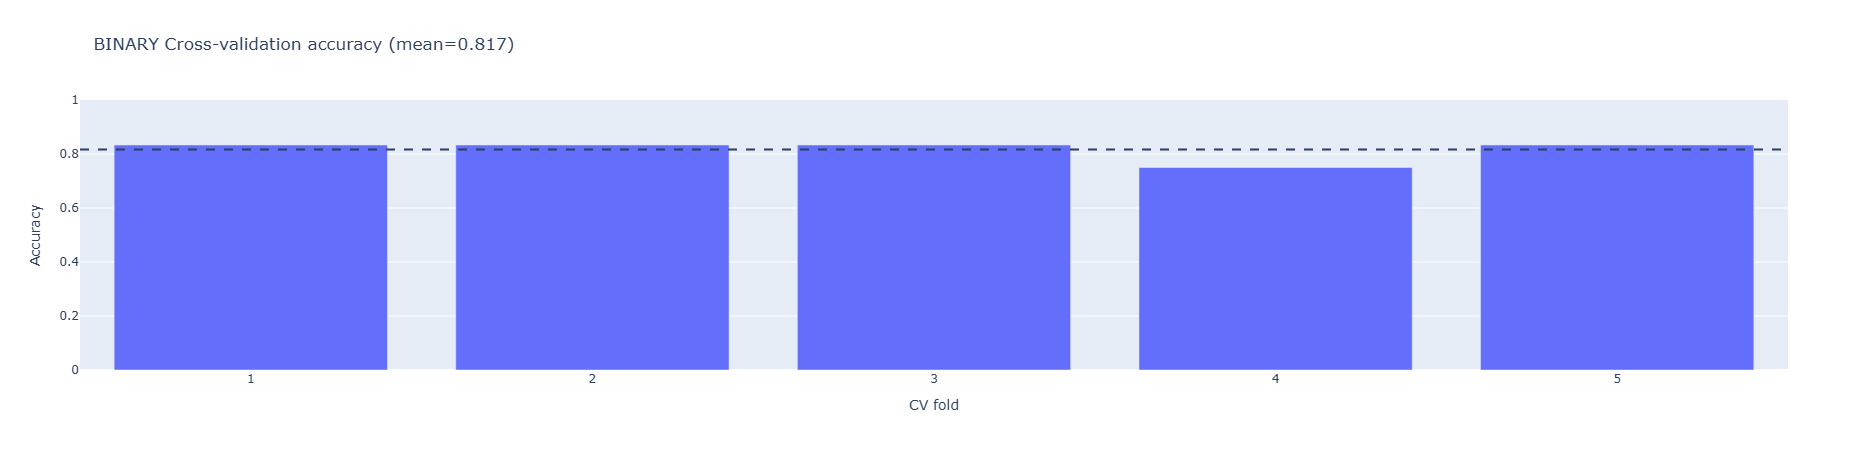

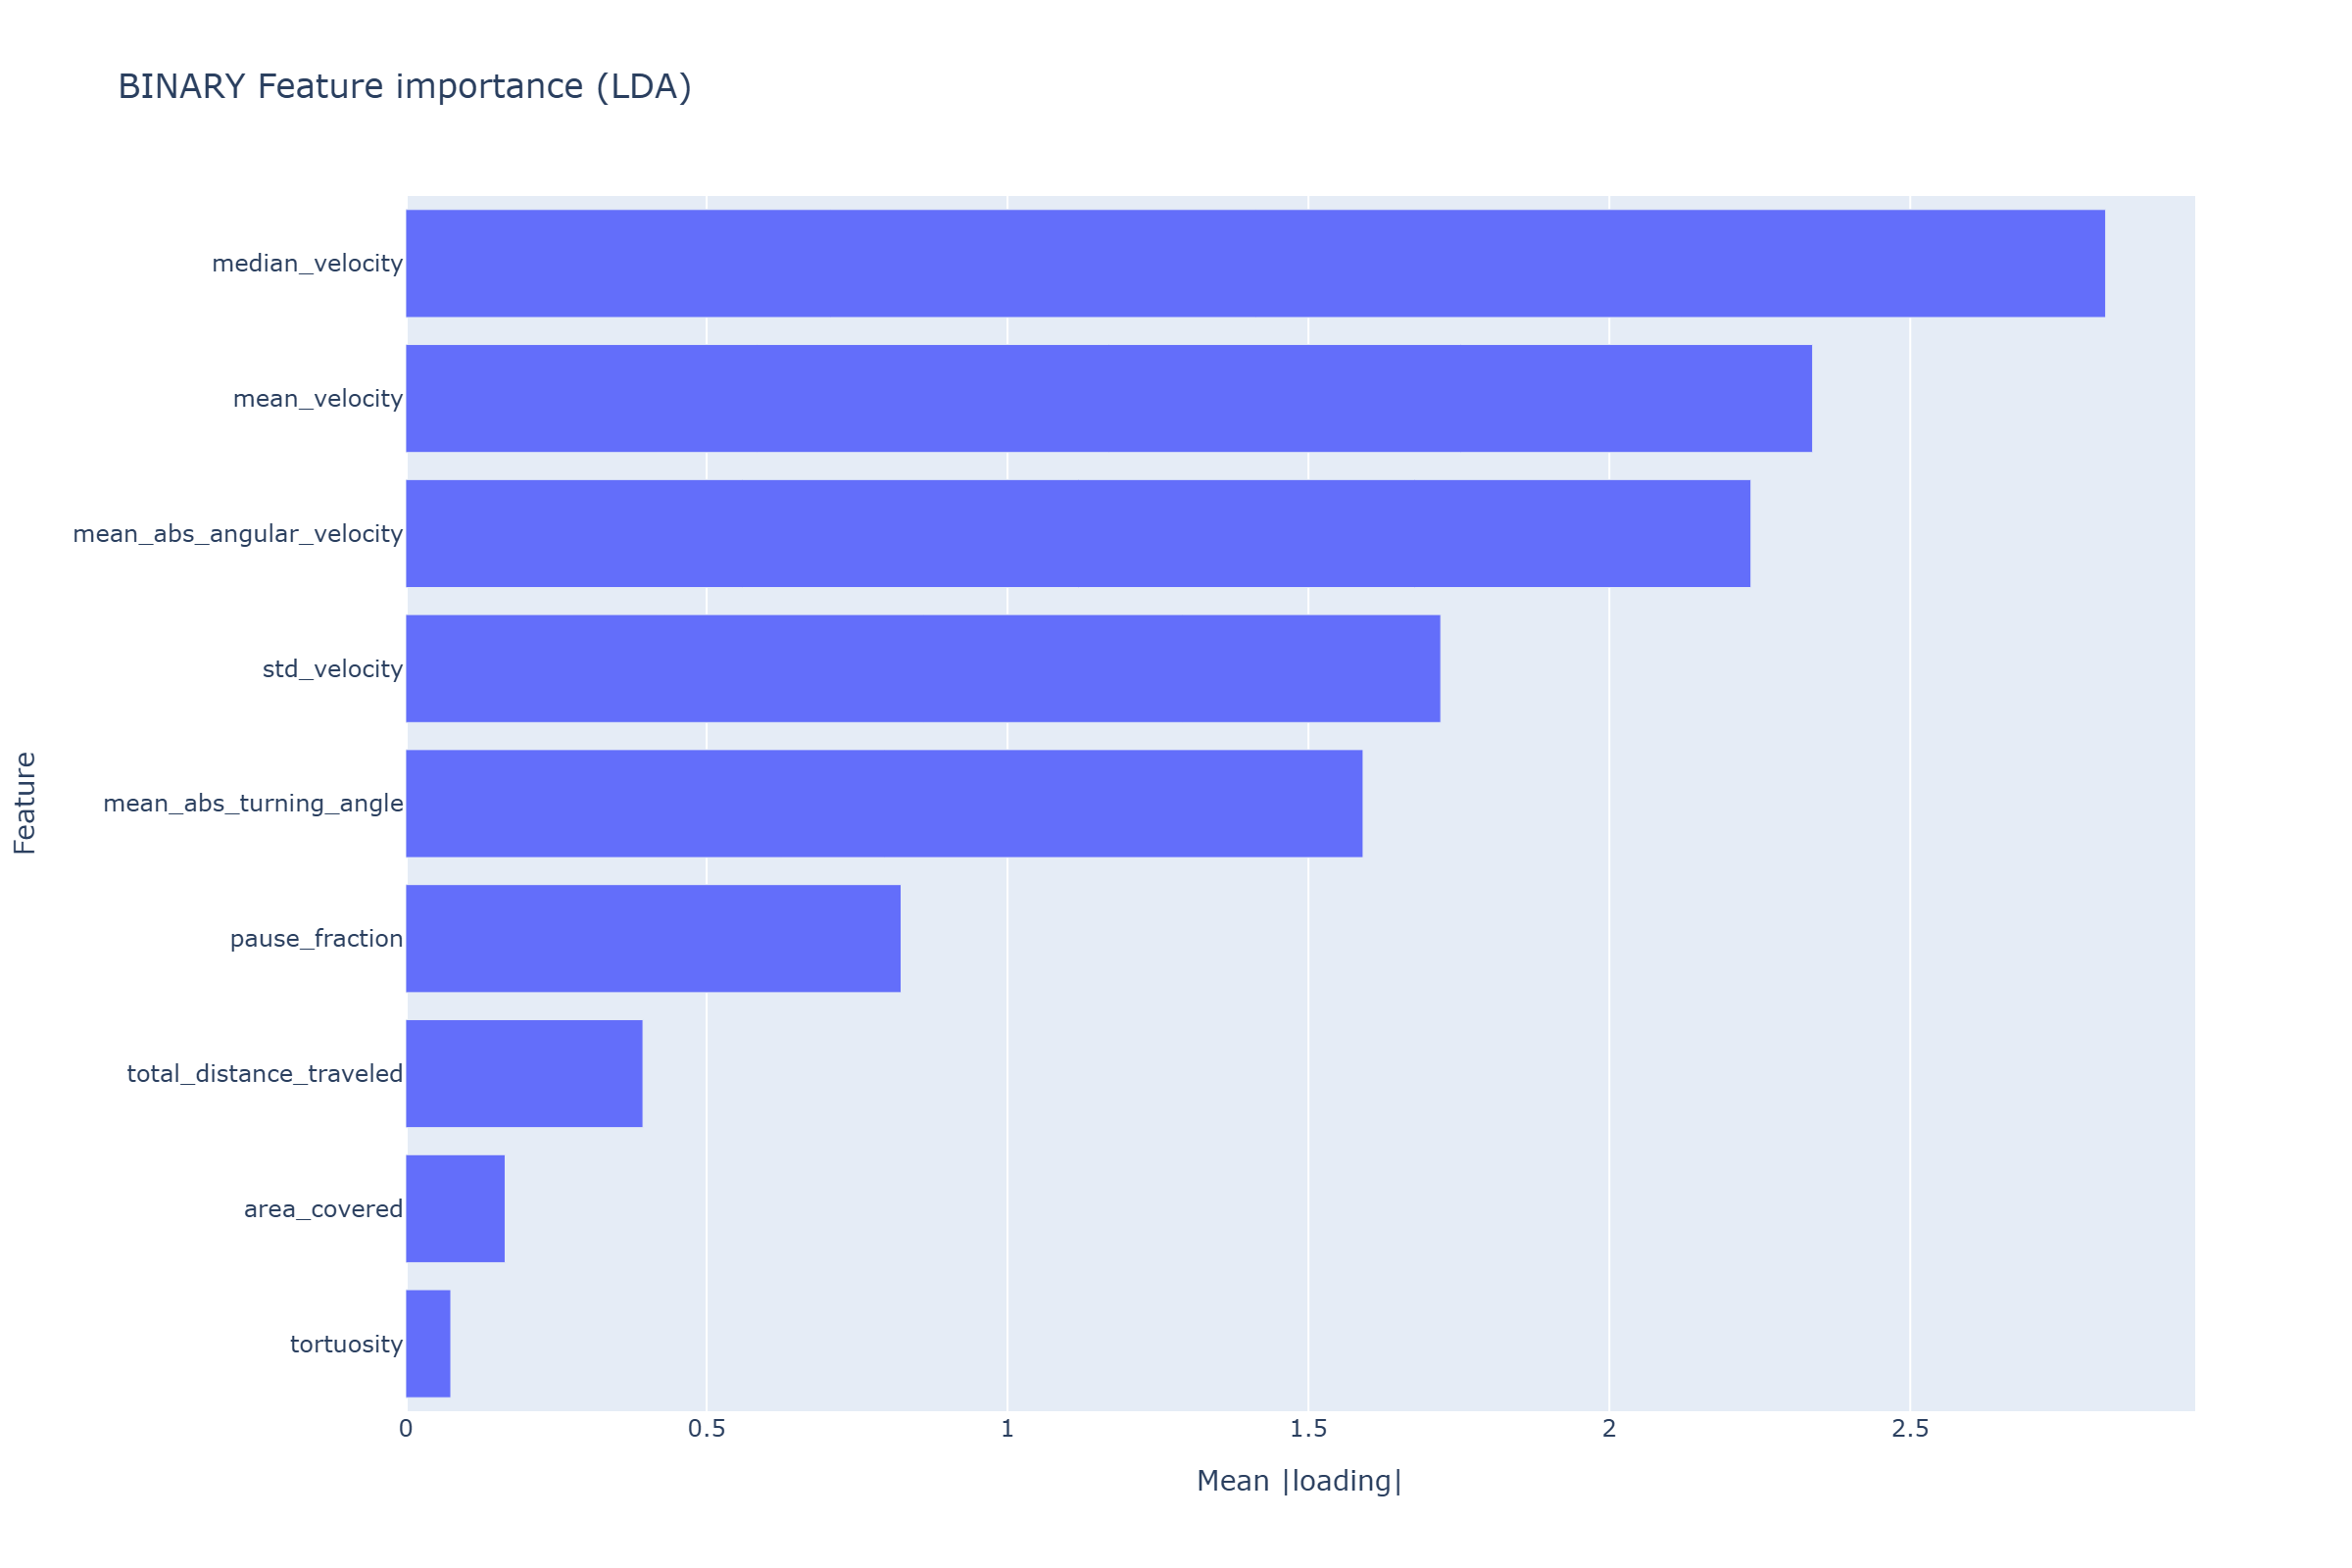

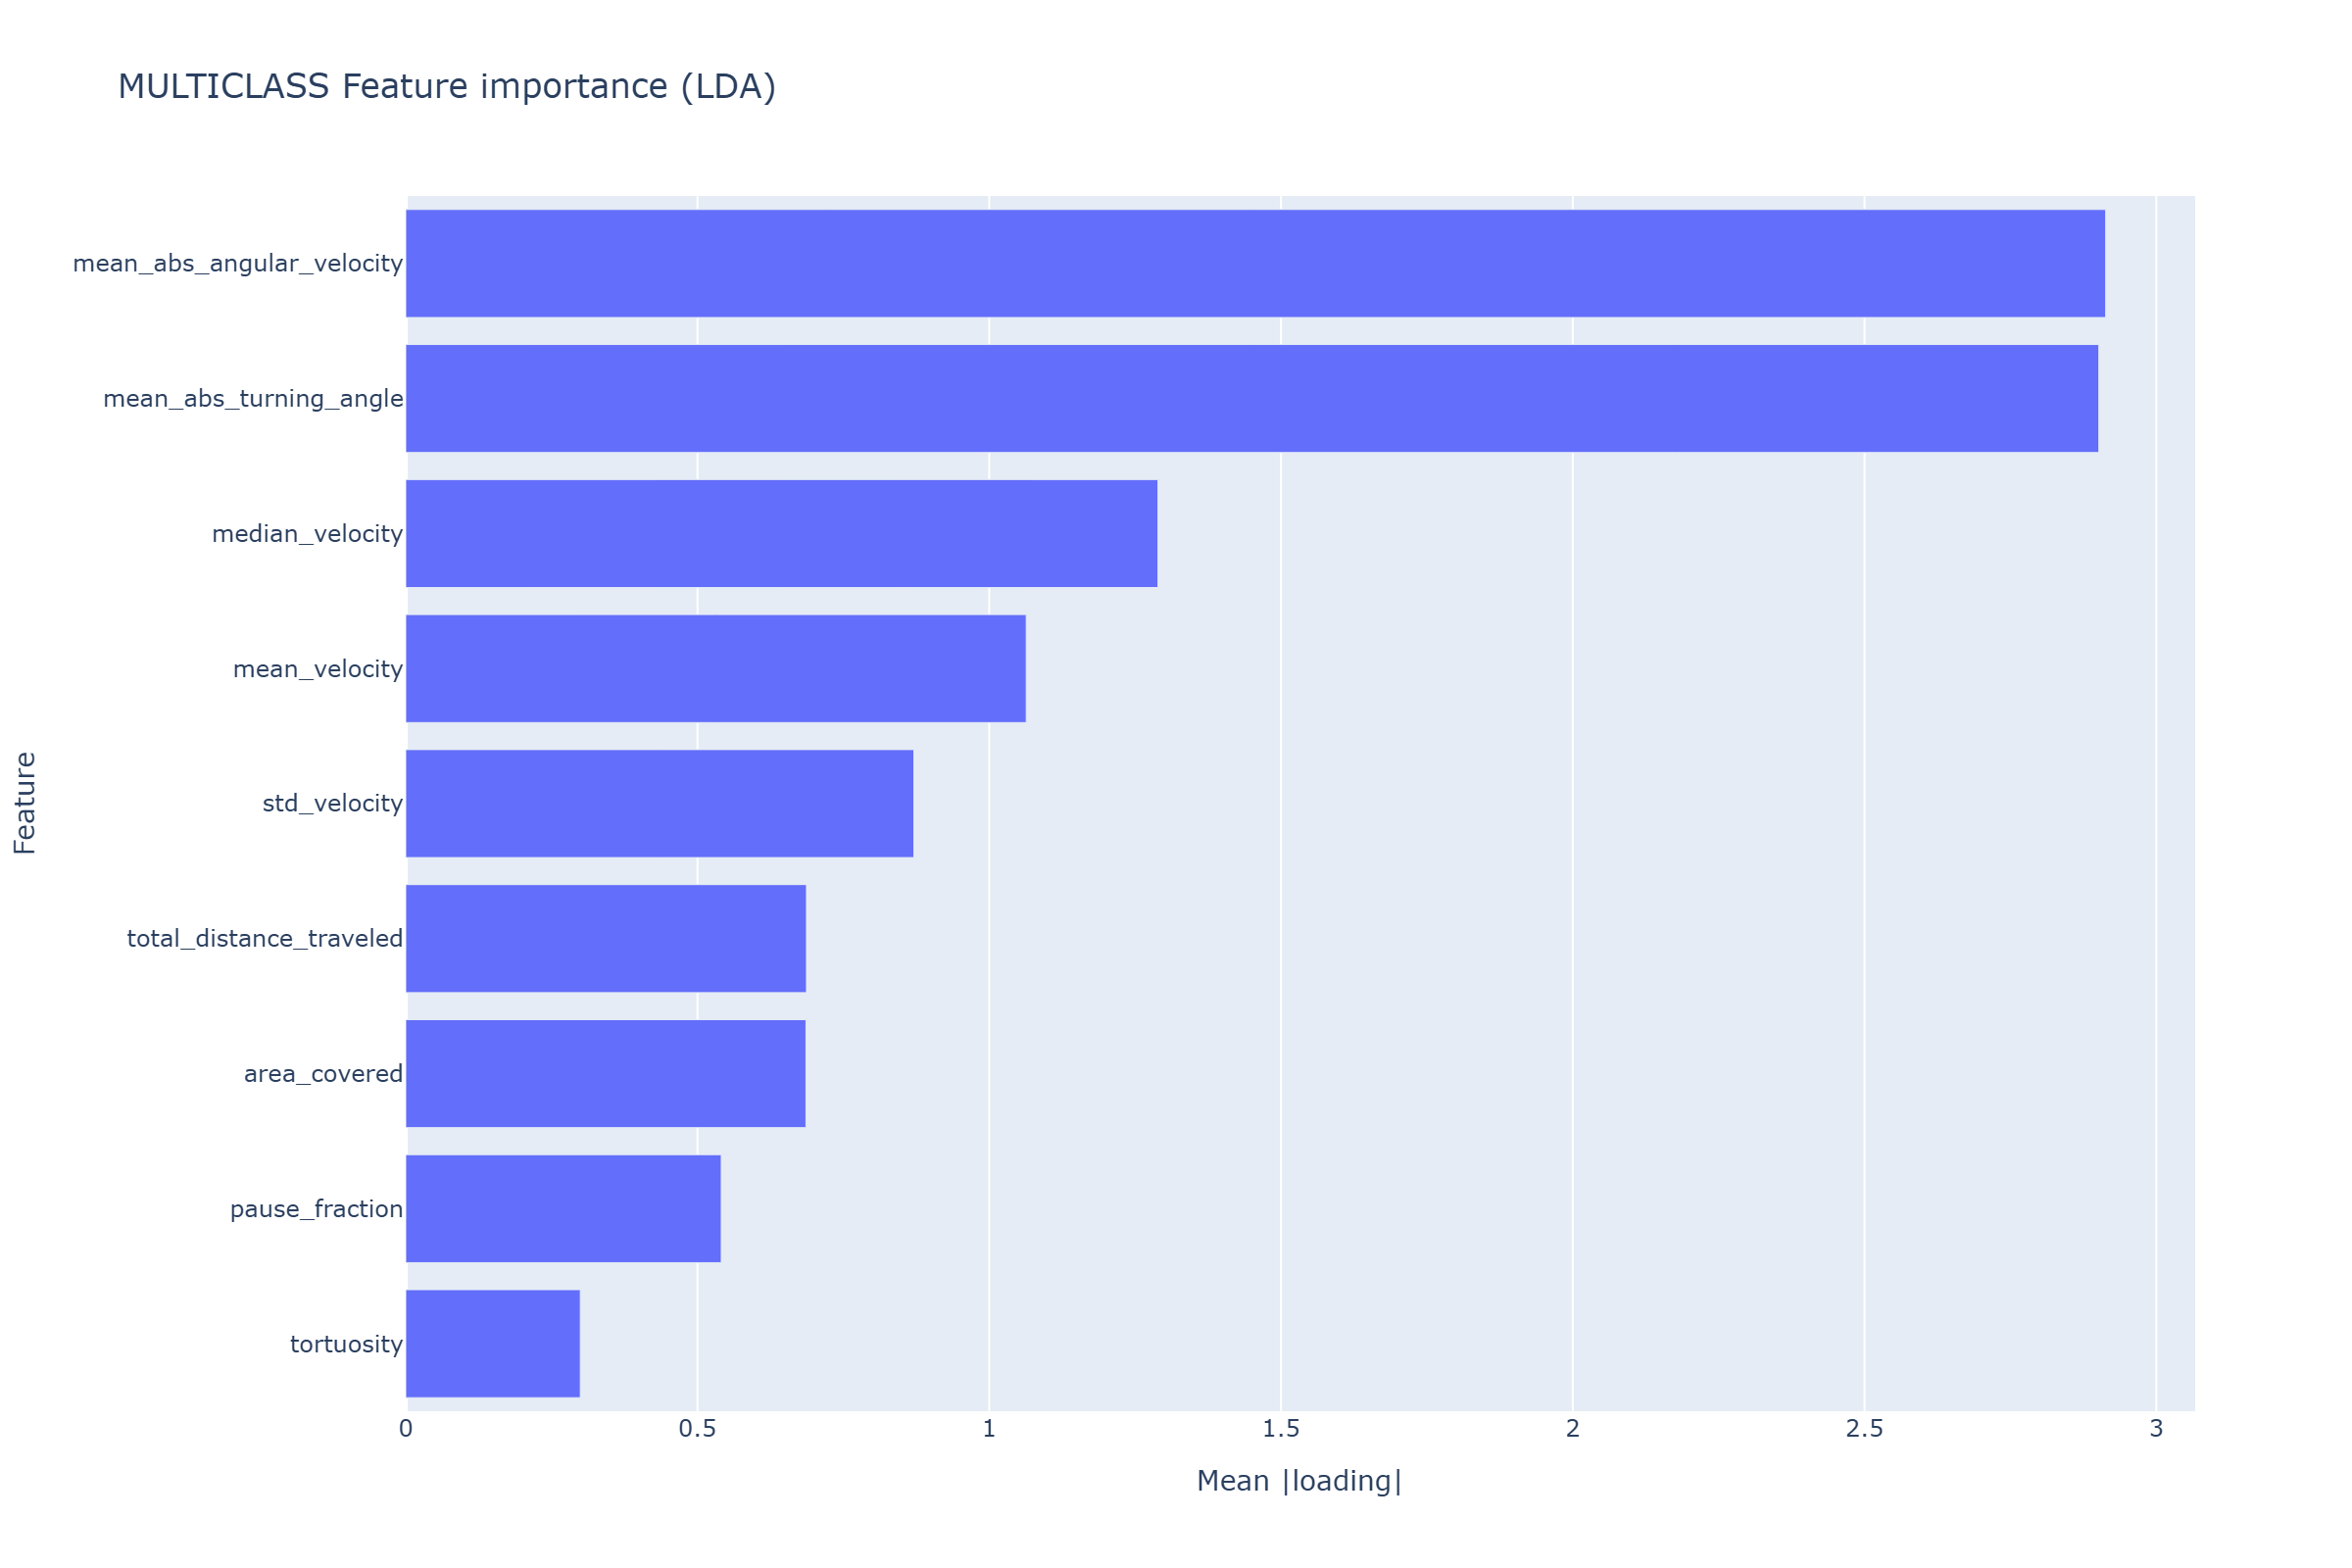

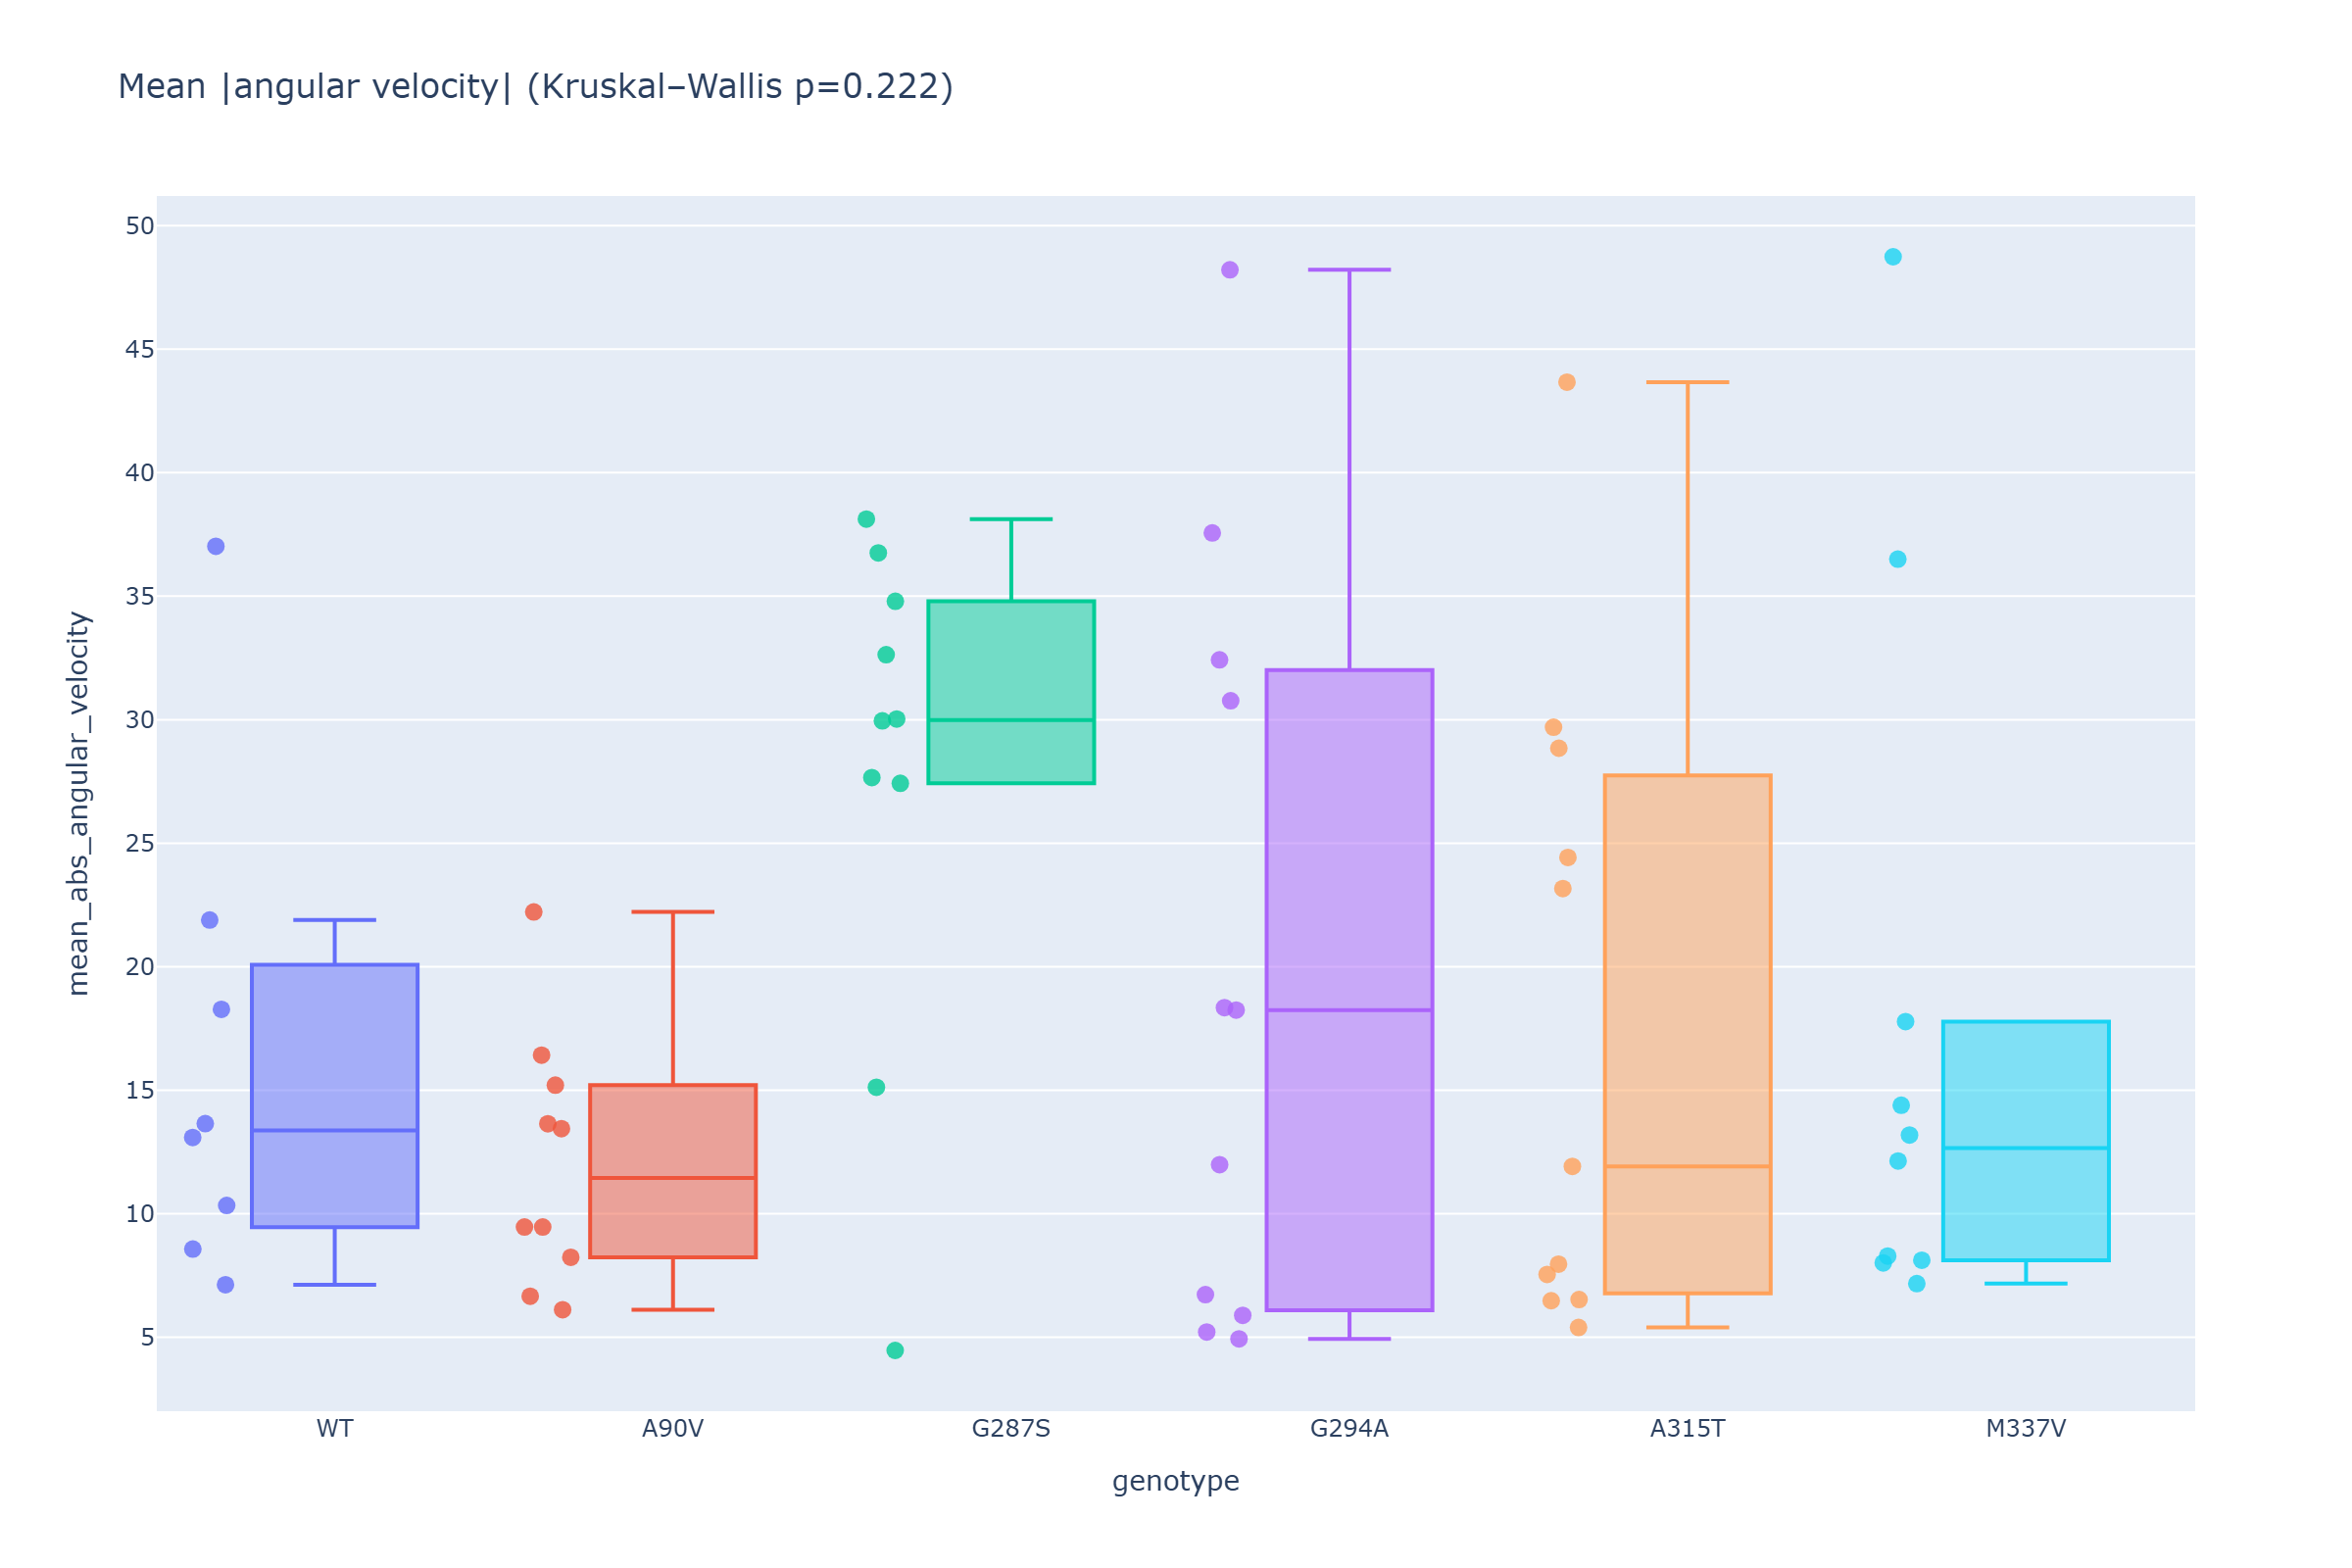

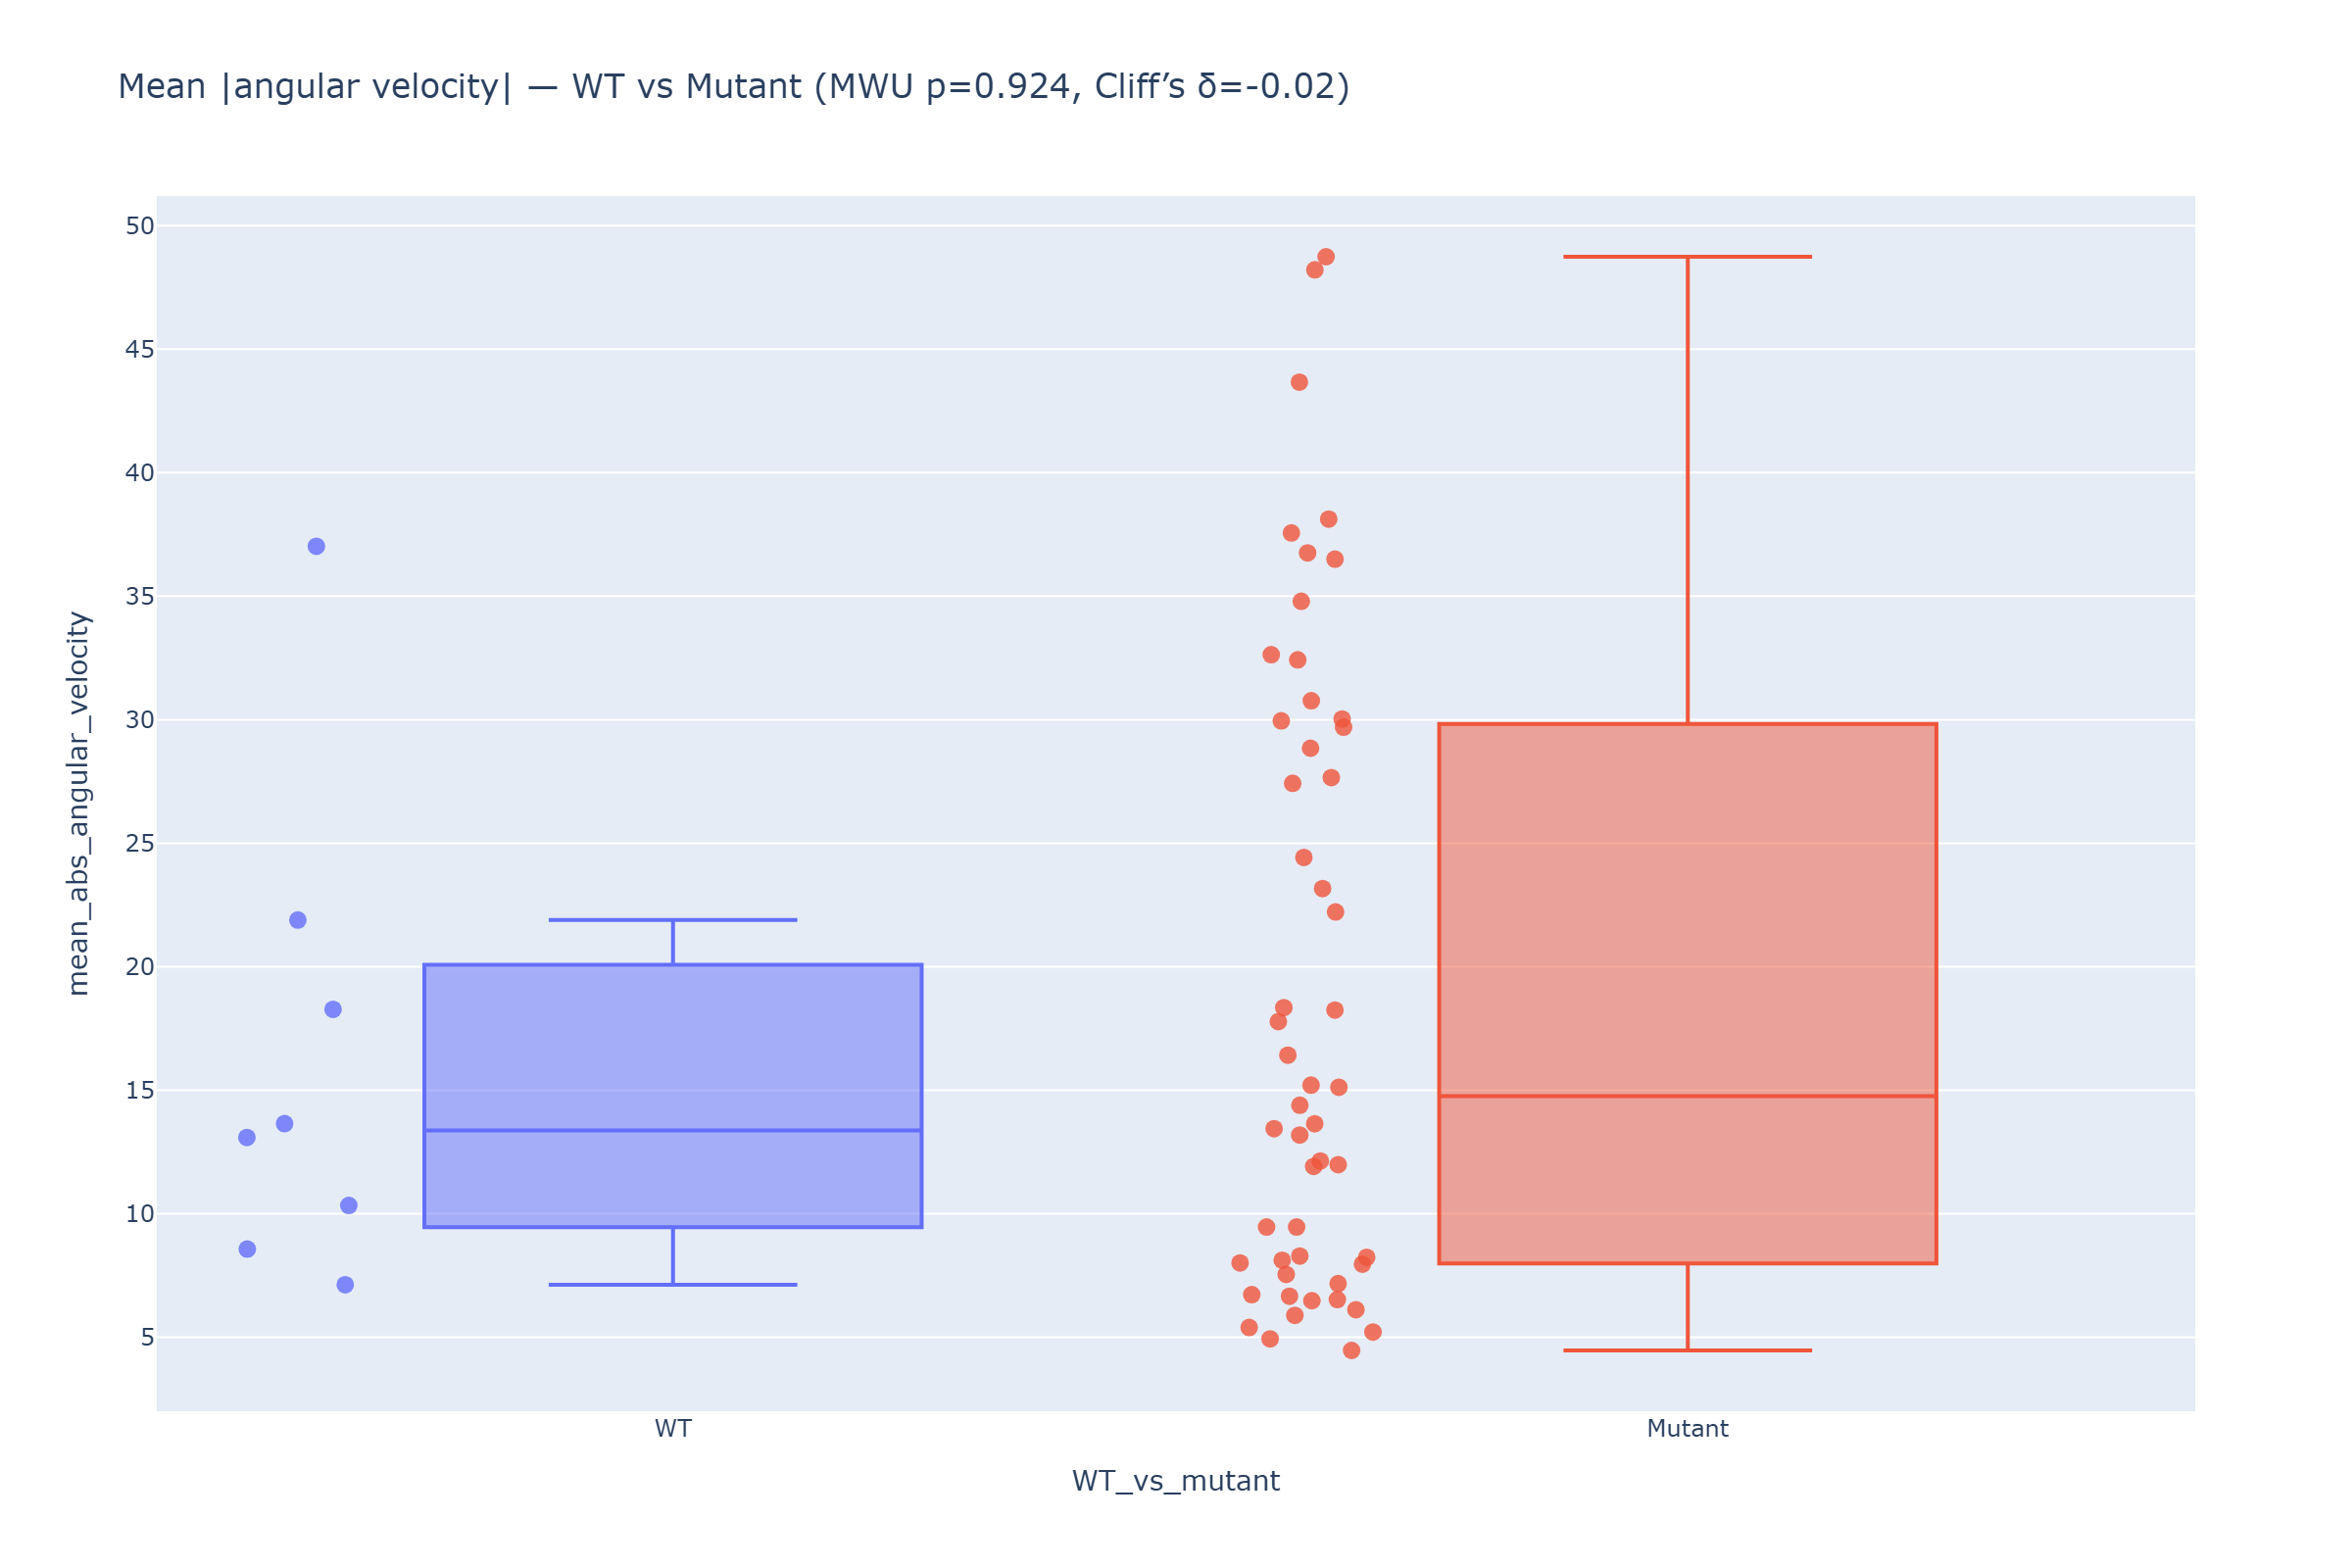

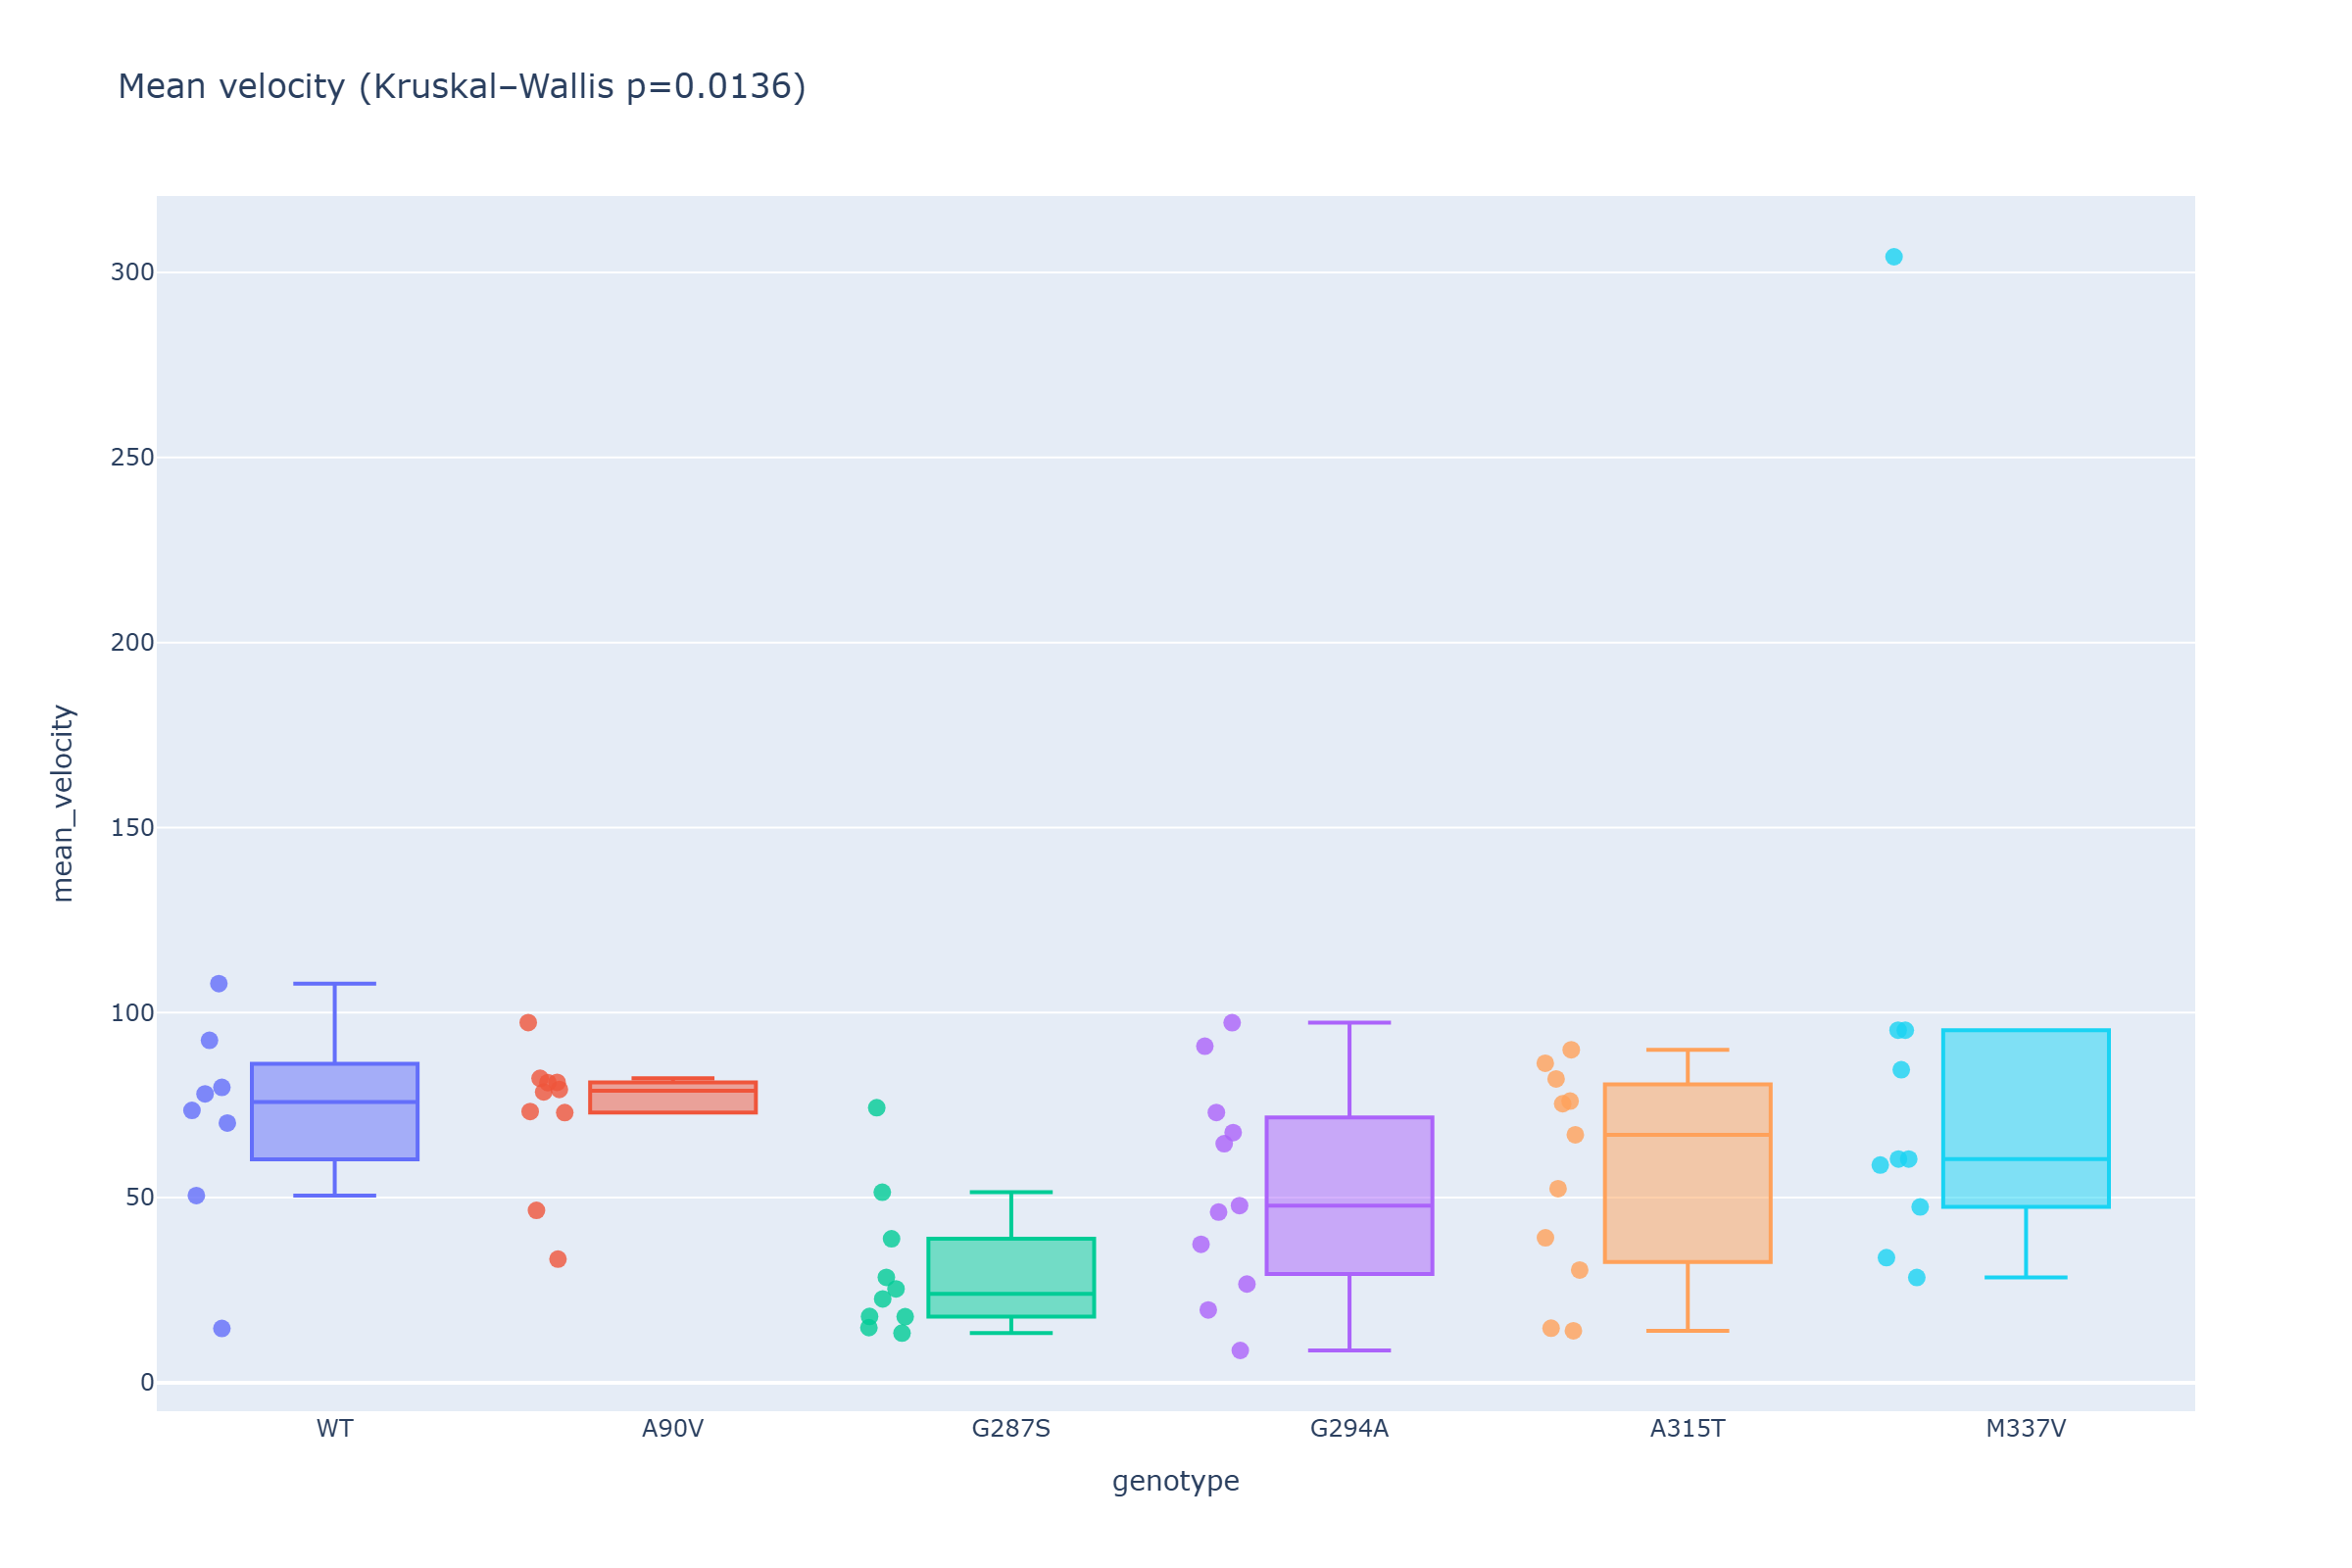

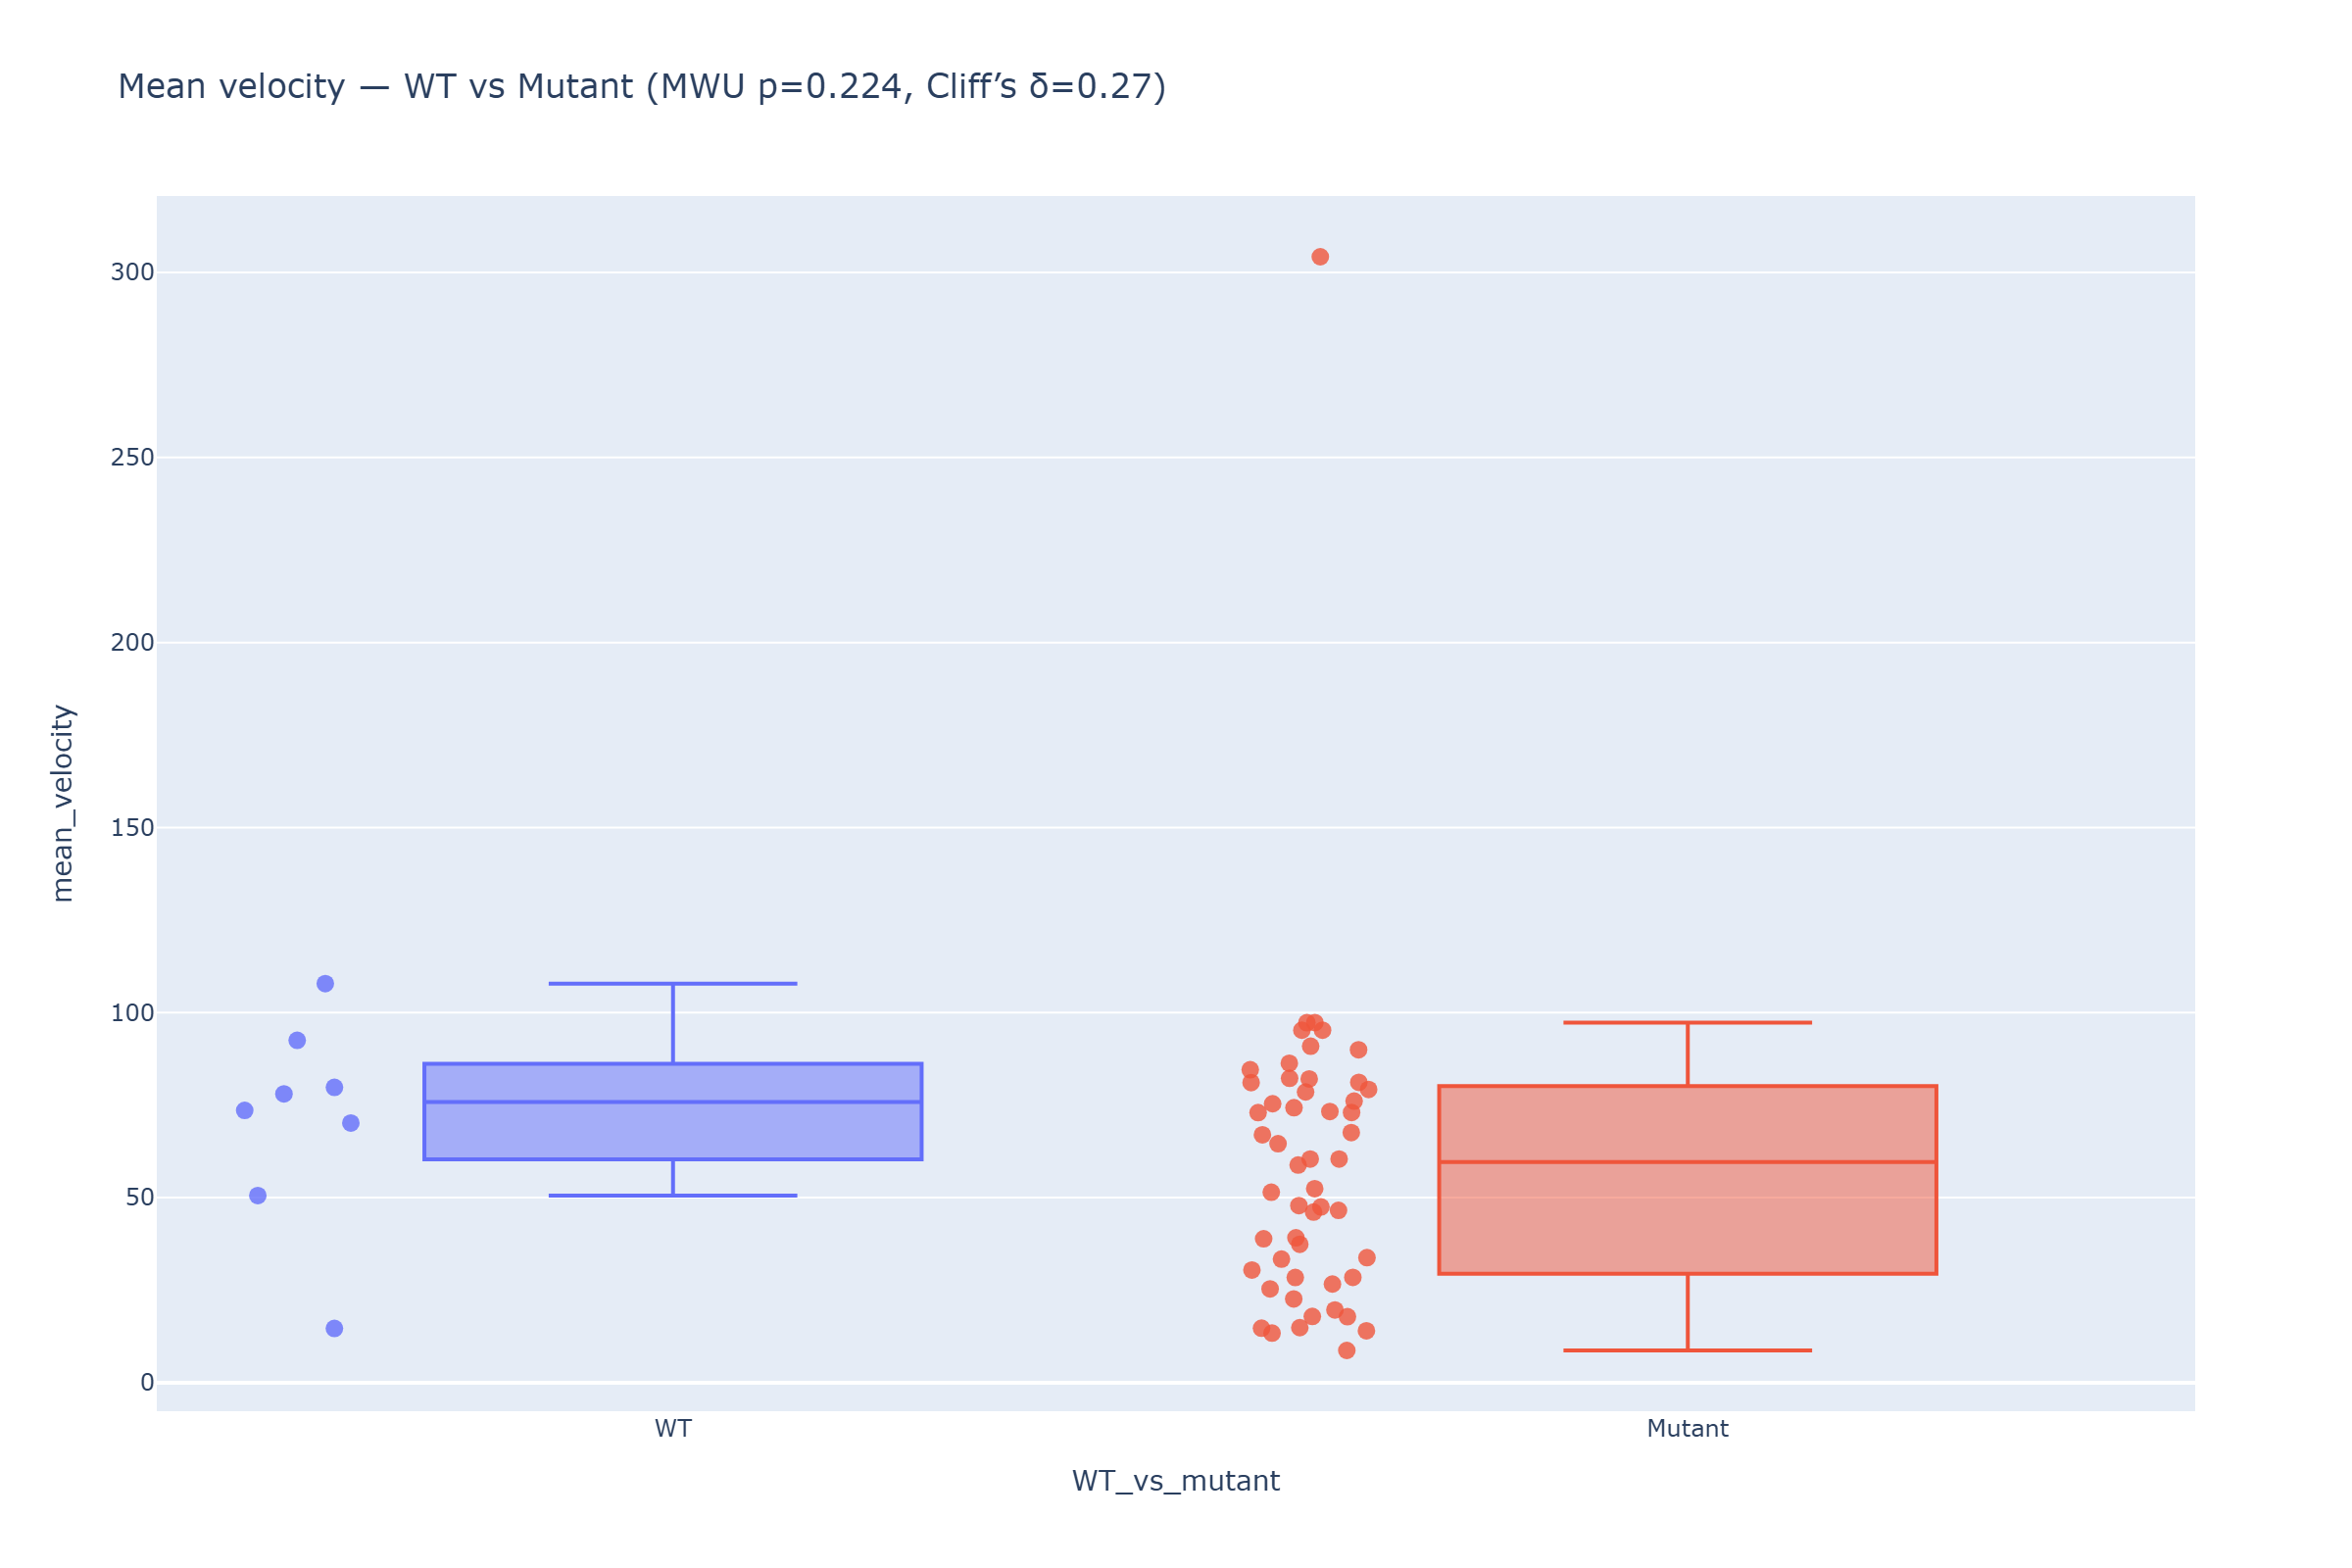

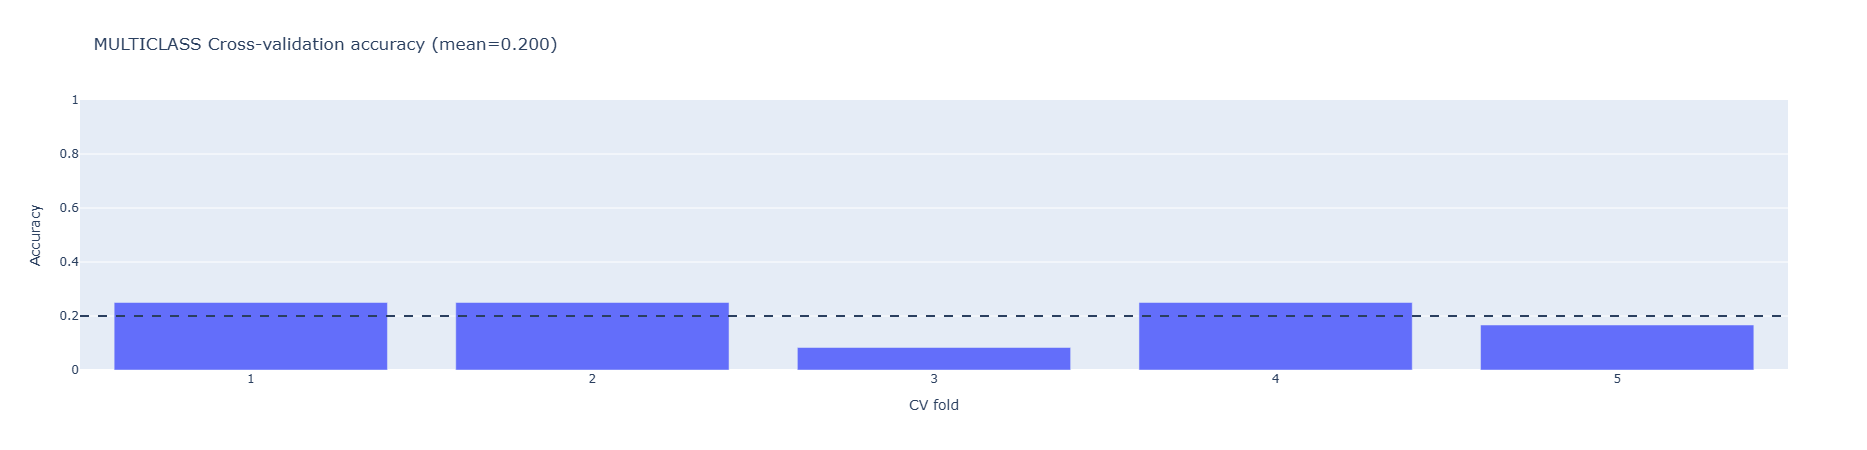

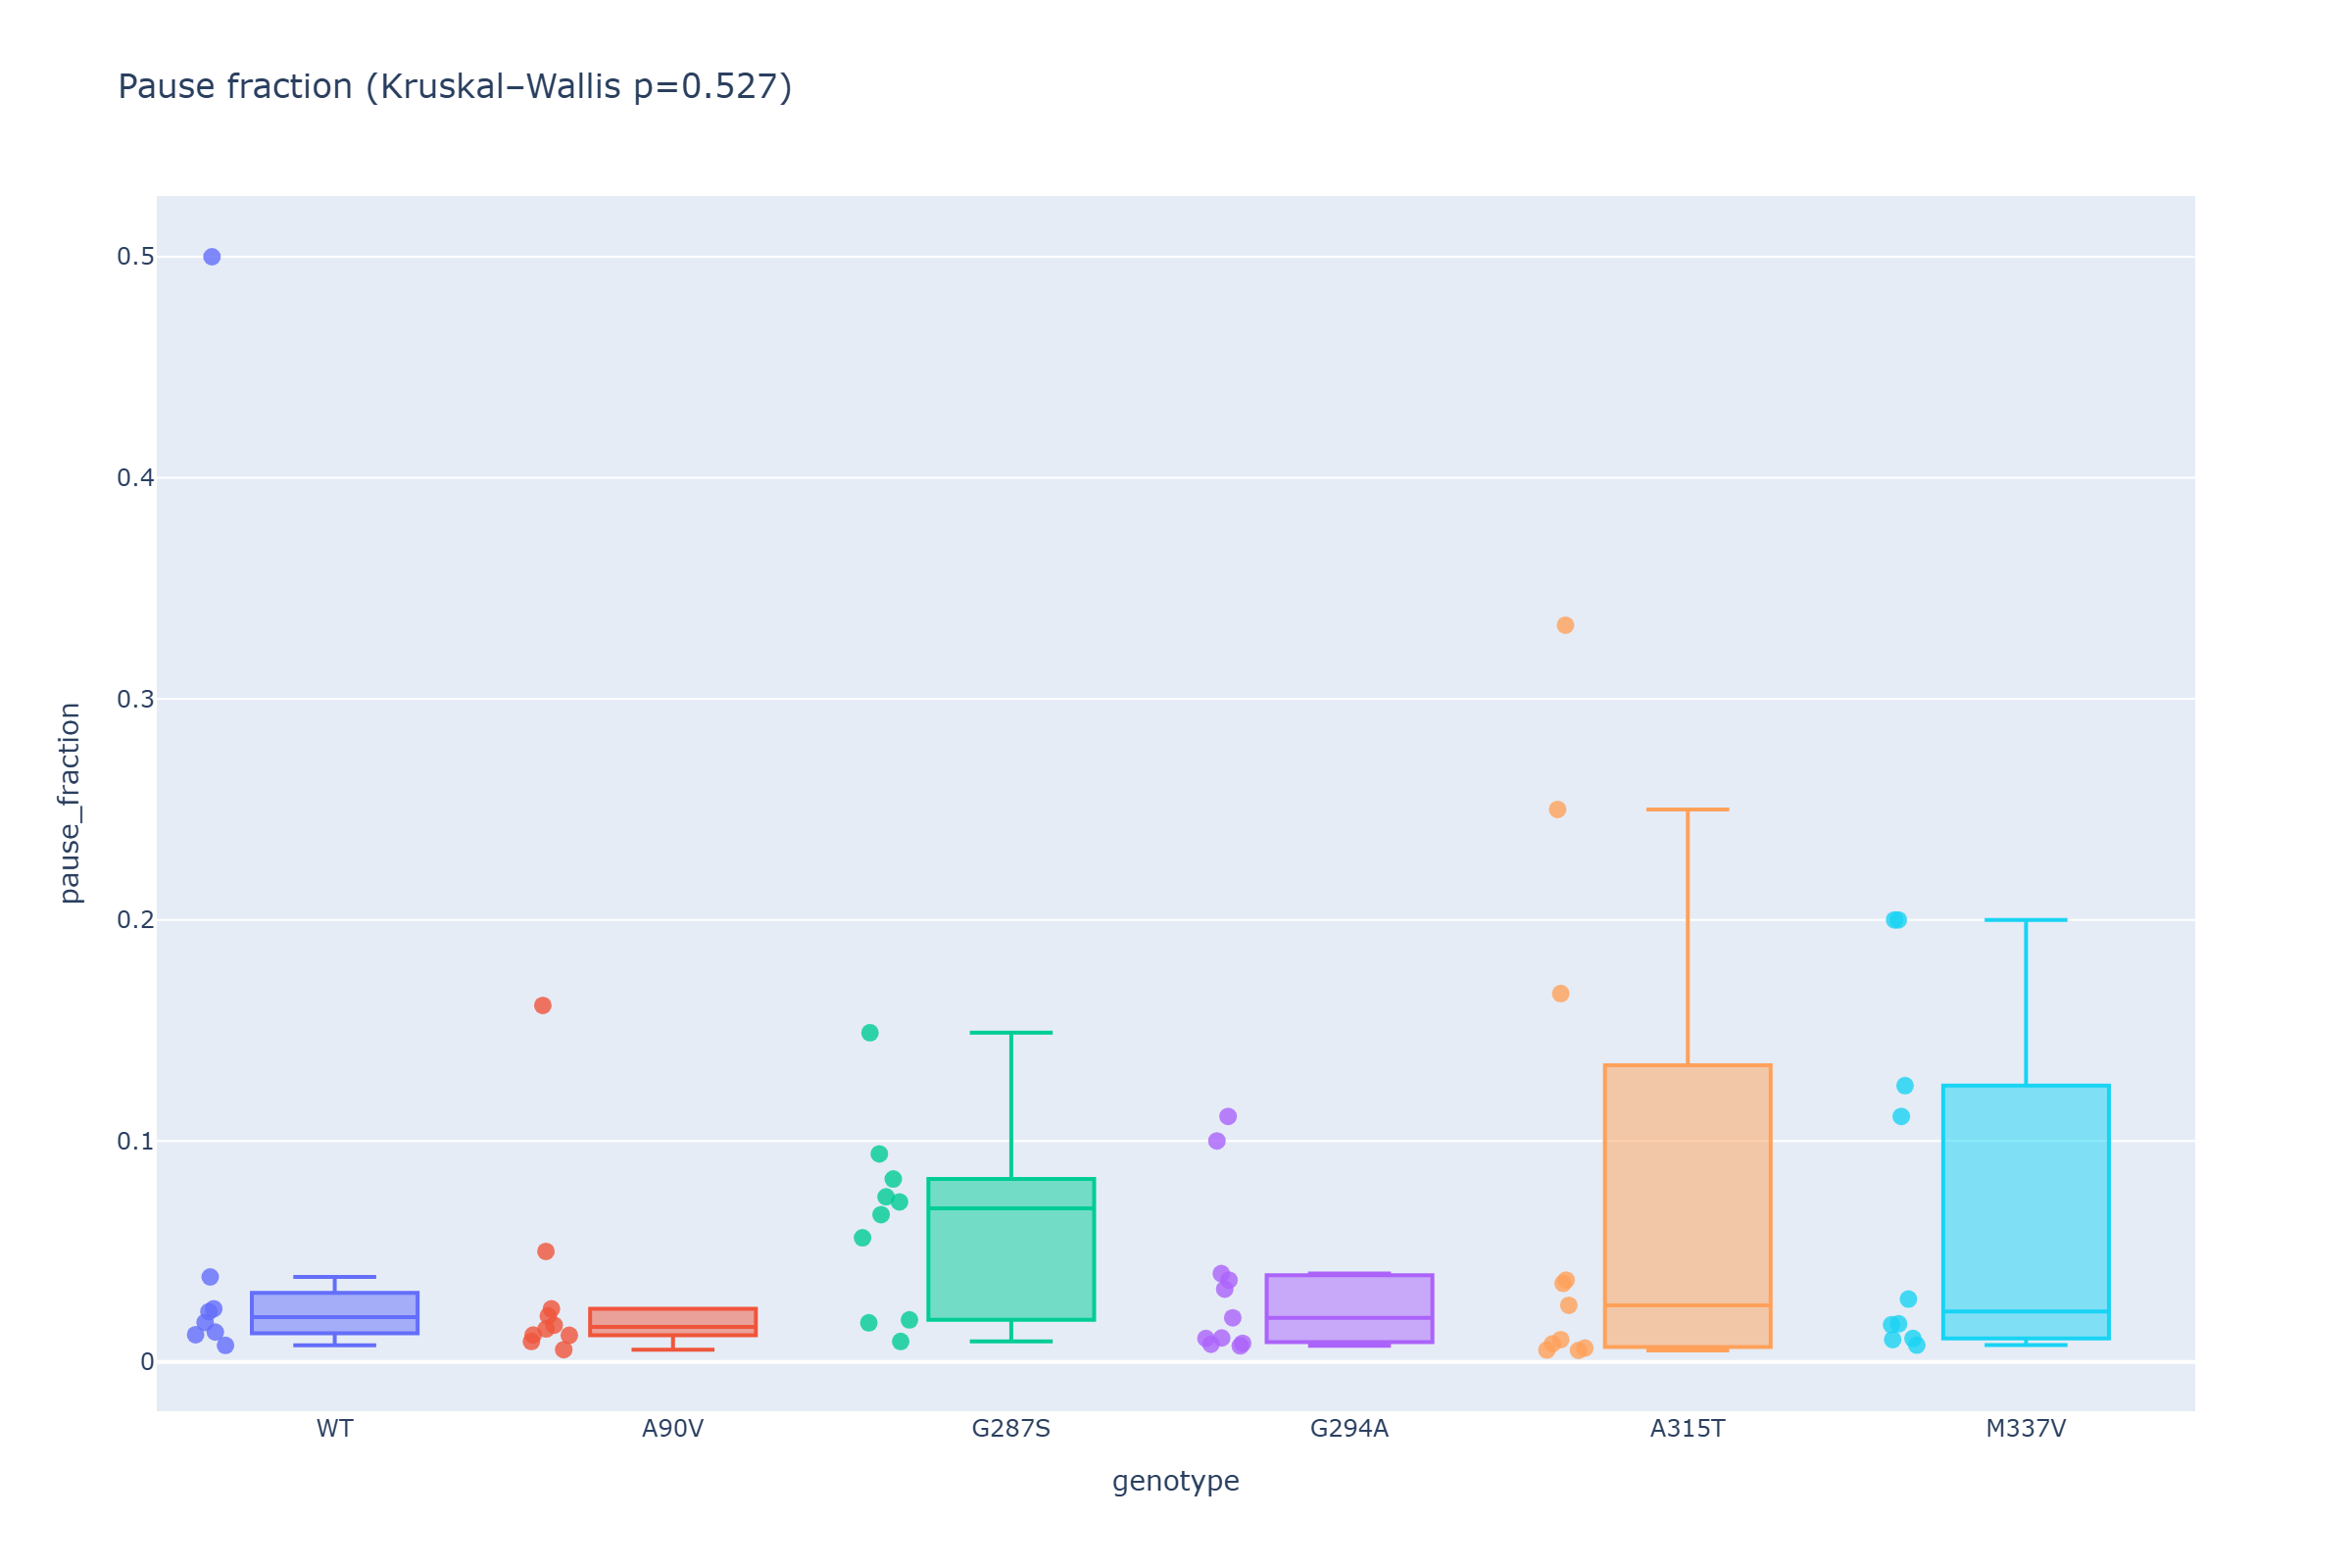

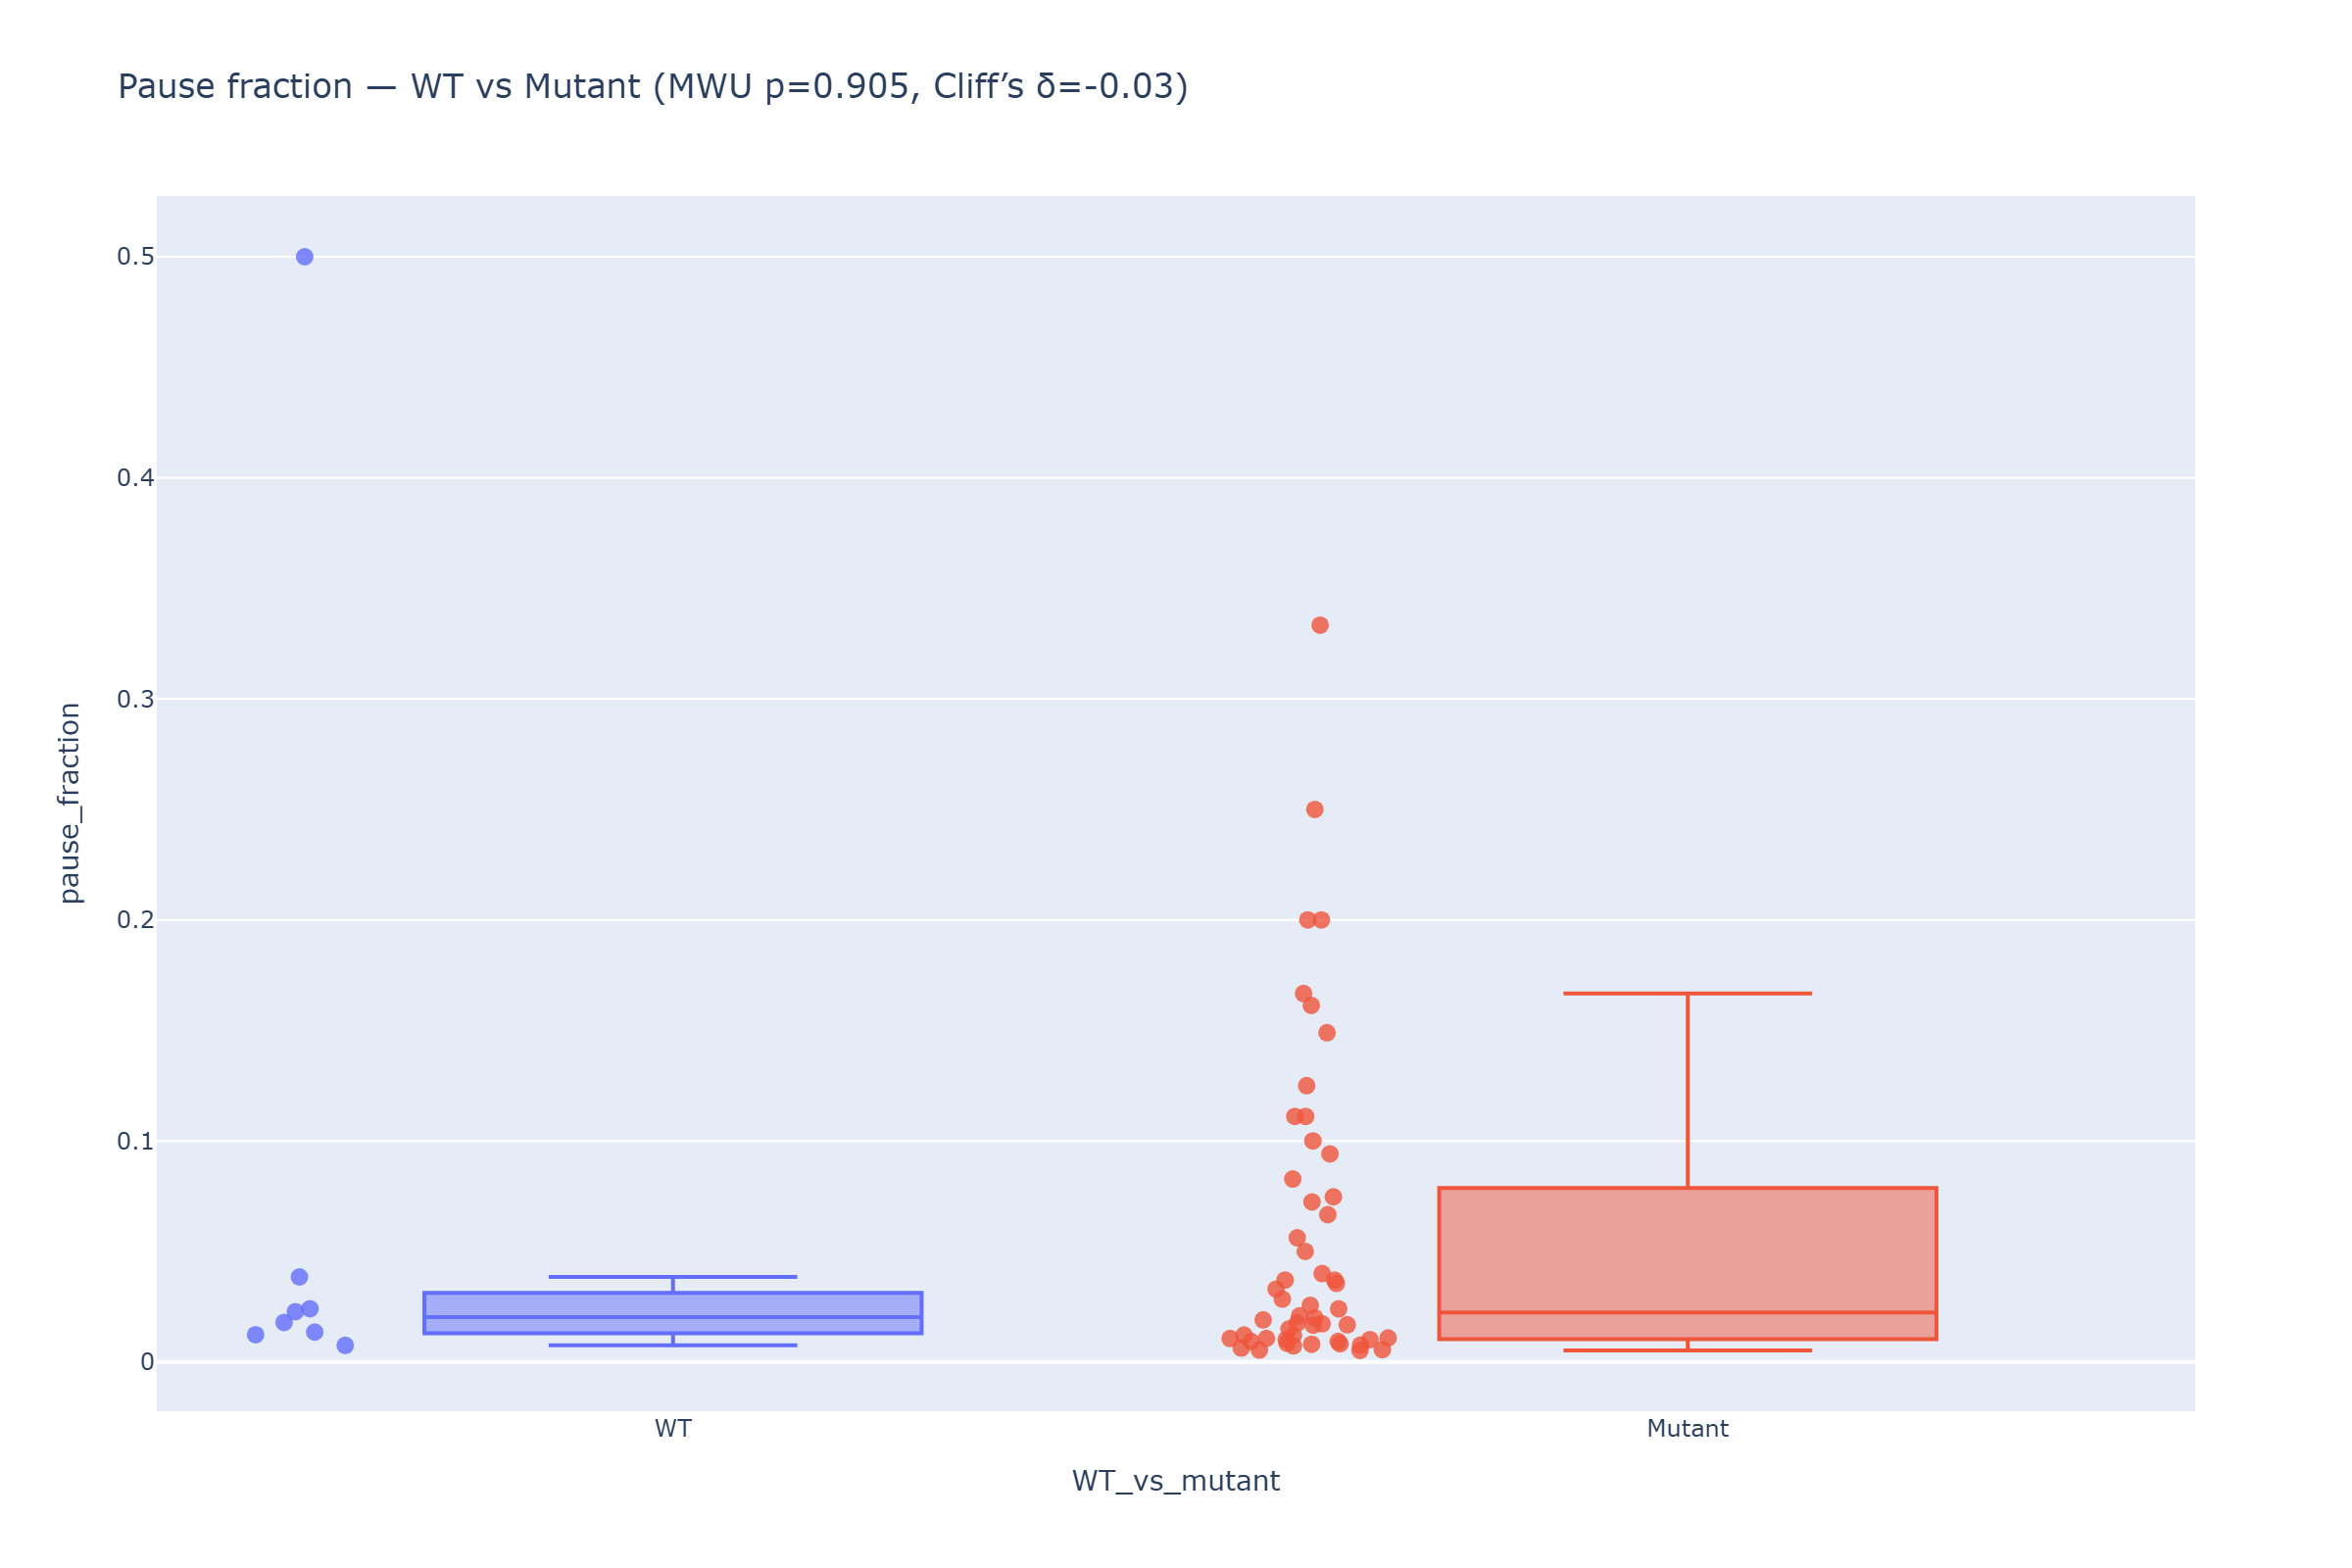

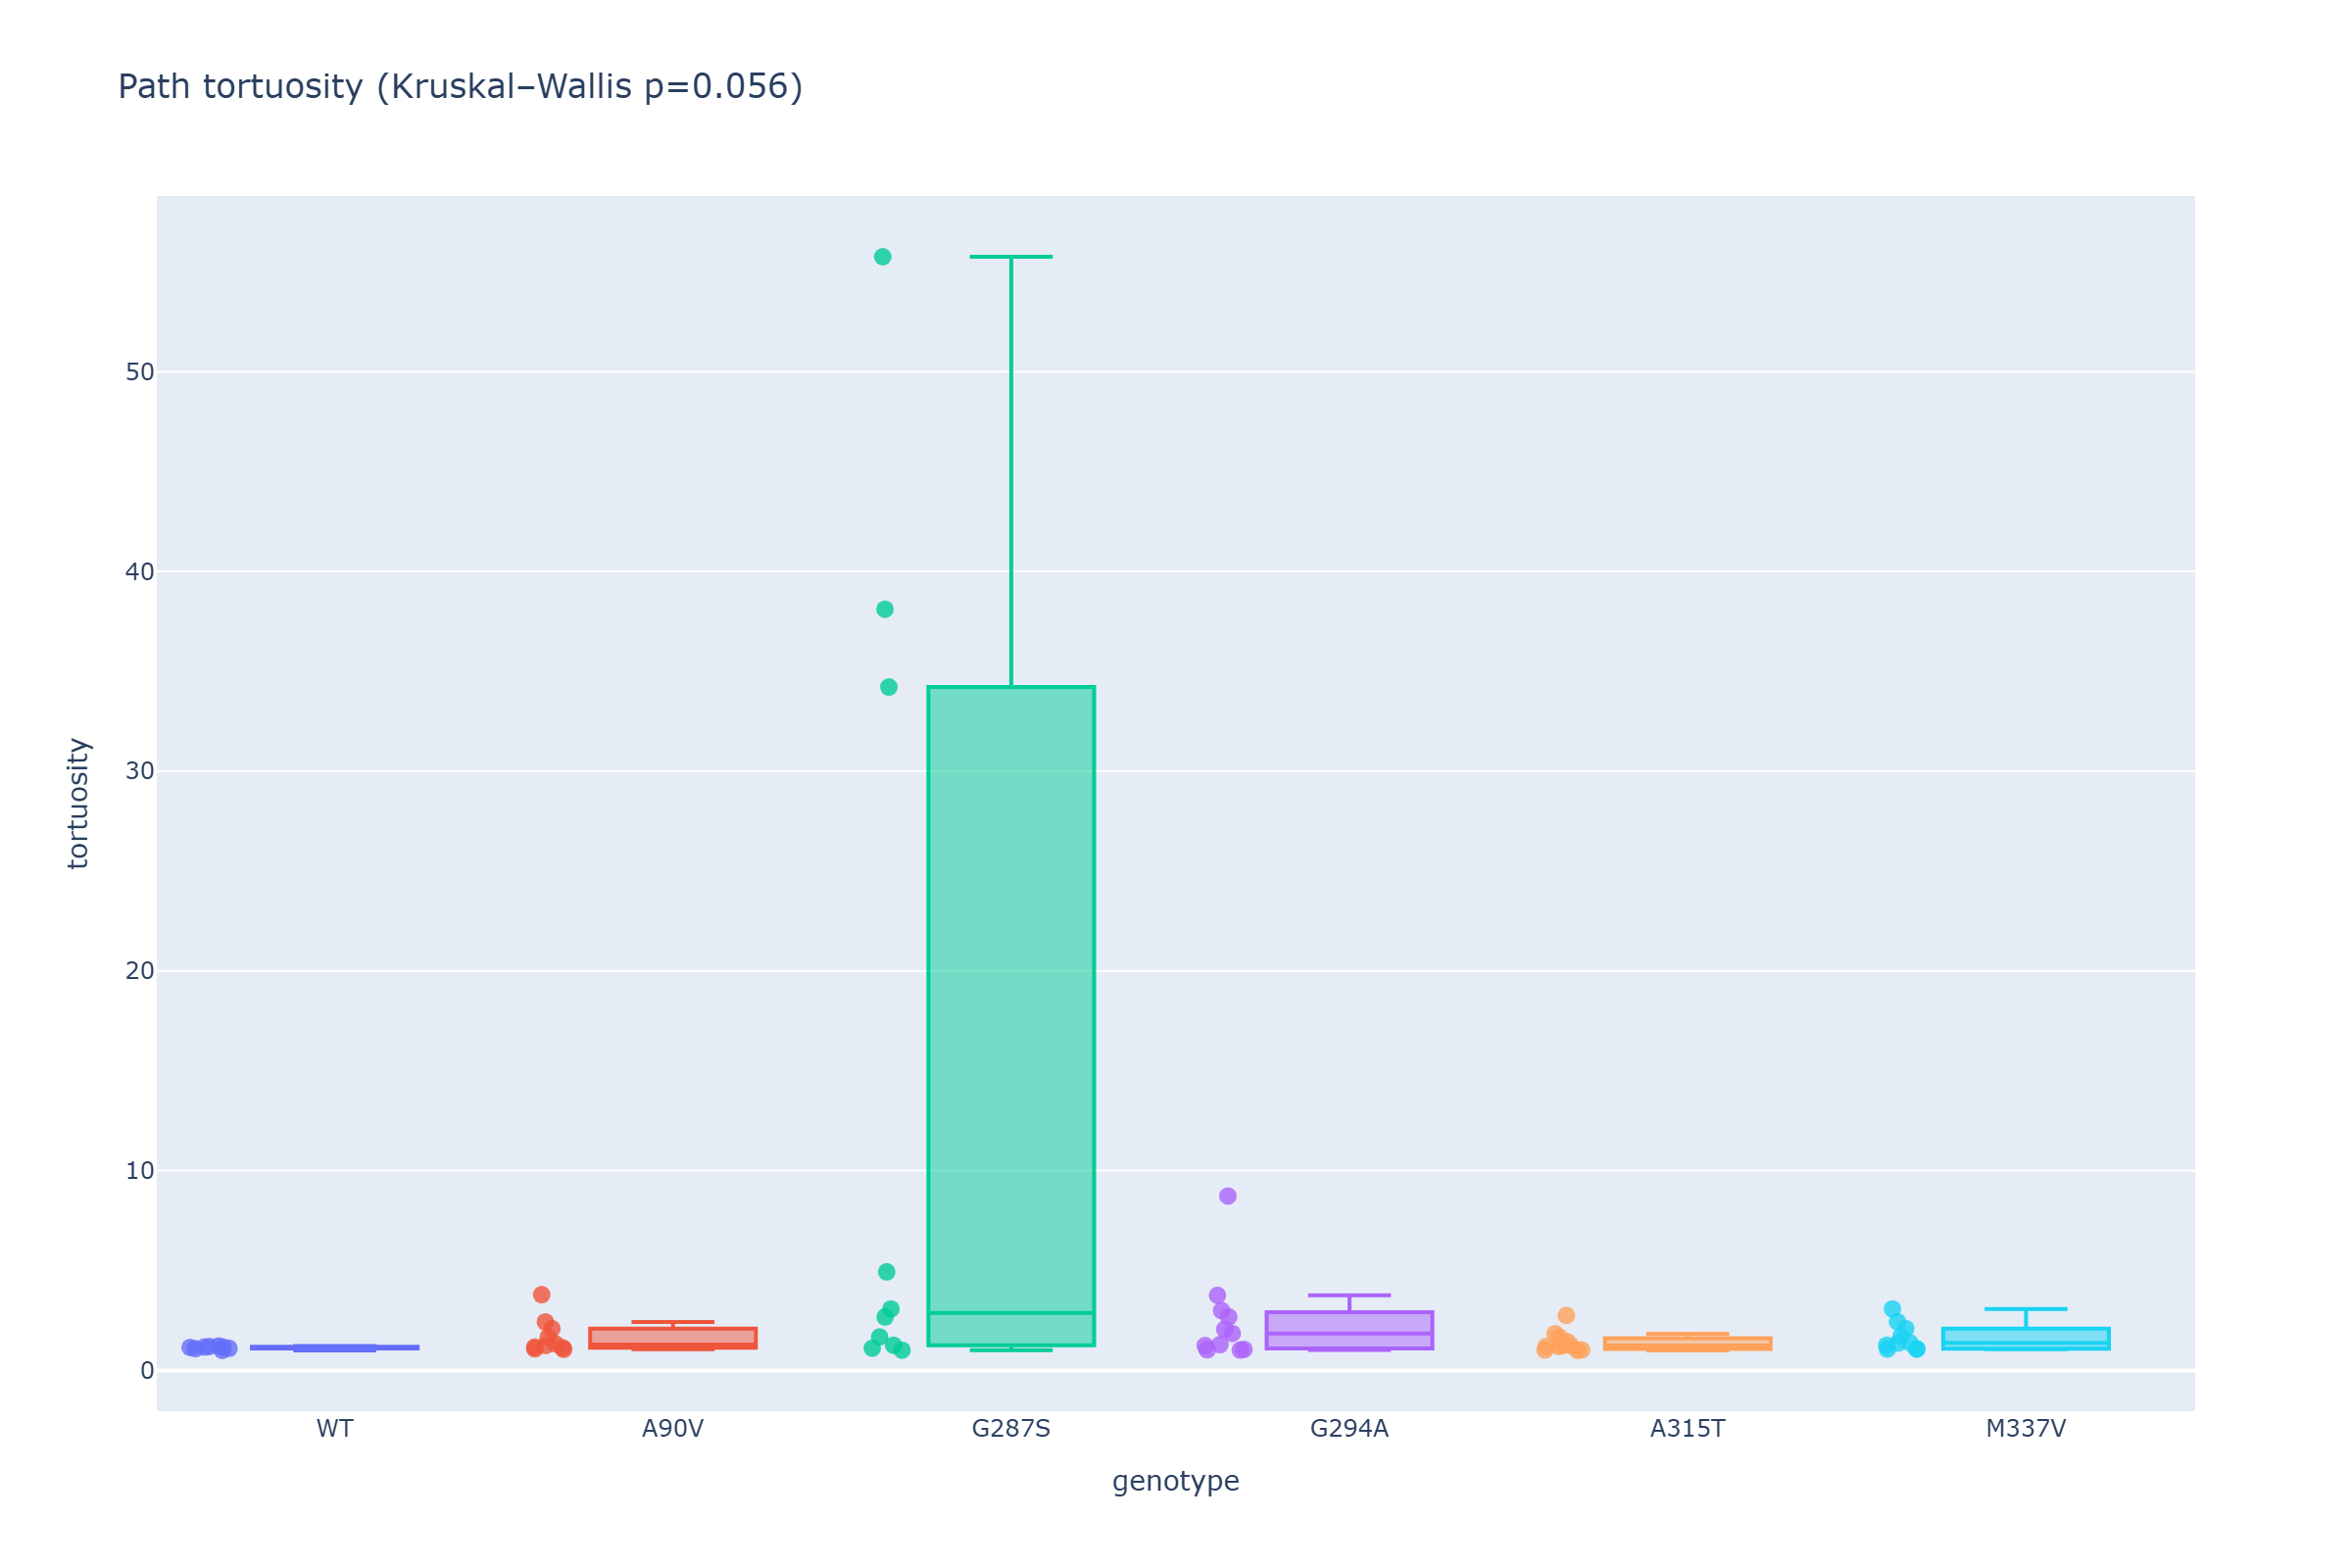

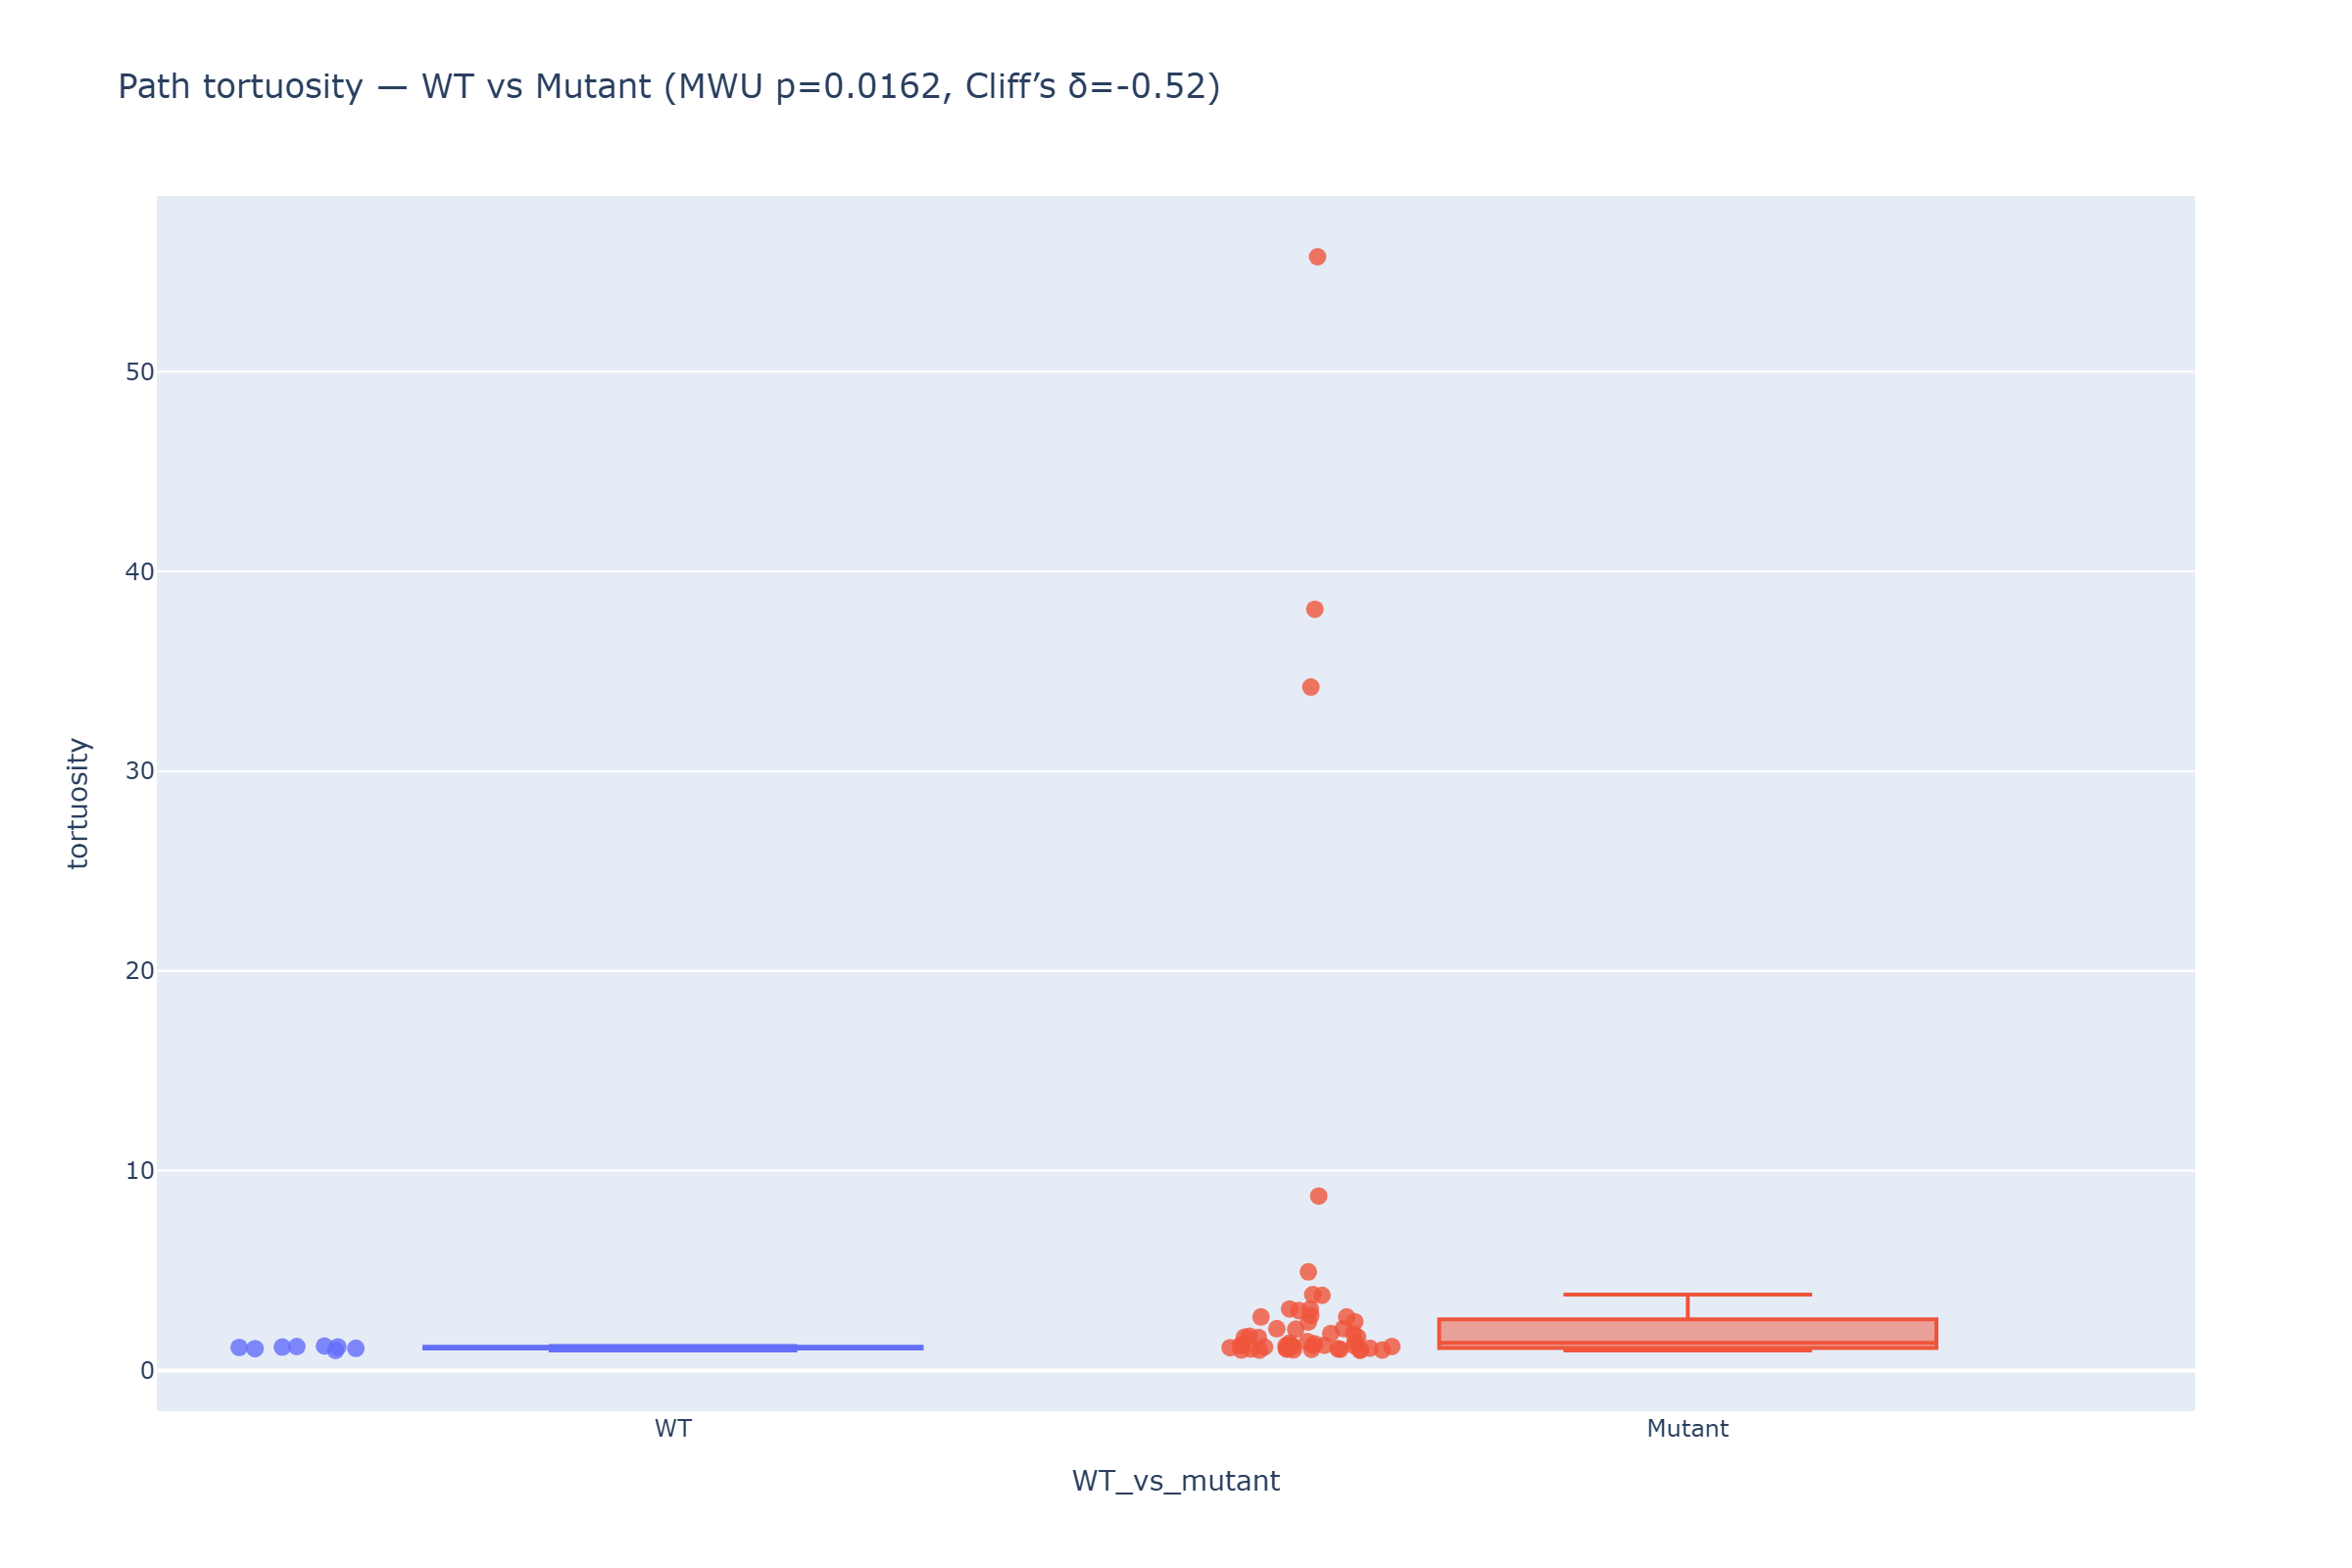

In [12]:
from pathlib import Path
from IPython.display import Image, display

img_dir = Path("figs")

for img_path in sorted(img_dir.glob("*.png")):
    display(Image(filename=str(img_path)))
